### 2491 - Machine Learning - Prof. Sabina Zejnilovic
Chachanidze, Giorgio (44944) | Dornigg, Thomas (41727) | Rodríguez, Beatriz (40757) | Schwab, Hanna (45166)

**Business Problem**<br>
In today’s financial markets, banks play a crucial role, especially when it comes to the decision on who should be granted a loan and under which market conditions. A major issue which financial institutions haveto face in this process is the risk of non-payment of its counterparty, meaning that banks need to pay special attention not to give a loan to risky borrowers. However, since banks have to analyze and process a certain amount of applications every day, this method is time-consuming and the result of the evaluation, when done manually, prone to errors. In this case, the best option for the bank is to evaluate the customer based on its previous credit history in a fully automatic way. To do so, statistical credit scoring algorithms are required to overcome those challenges. These algorithms, which compute probability of defaults for each applicant based on the credit history of its customers, are the main methods which financial institutions nowadays use to determine whether a loan should be granted to a borrower or not.

Regarding the machine learning problem we are facing in this project, since we are trying to build and train a model to predict whether a loan holder should be granted a loan or not, it is clearly a classification problem where we have two different classes to group our data:<br>
- default or <br>
- non default<br>

The data for this project can be found on <a href="https://www.kaggle.com/c/home-credit-default-risk">Kaggle</a>.

In [8]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 }else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Group Project: Credit Risk Modeling

<p align="center">
  <img width="460" height="360" src="https://pngimage.net/wp-content/uploads/2018/06/home-credit-png-5.png">
</p>

#### Libraries

In [383]:
# @hidden
import pandas as pd
import numpy as np
import os
import pickle
import time
from collections import Counter
from io import BytesIO
import requests
import warnings
warnings.filterwarnings("ignore")

# import sklearn packages for modelling
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import missingno as msno
from sklearn.inspection import permutation_importance
from sklearn import metrics
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

# Import ML-Classifiers
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Data Visualization set up
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Image, display
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

#setting max number of columns to be displayed to 100, to get a better view.
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

#### Data Import

In order to handle the massive amount of data, the group first downloaded the datasets from Kaggle with the link as provided above. Since we only used the <code>**application_train.csv**</code> dataset, we converted this file in the beginning with the memory reduction function from below, splitted the converted file into two parts and uploaded both to Github.

In [384]:
# @hidden
url_1 = 'https://raw.githubusercontent.com/ThomasD96/NovaSBE_Machine_Learning/main/datasets/home_credit_01.csv'
url_2 = 'https://raw.githubusercontent.com/ThomasD96/NovaSBE_Machine_Learning/main/datasets/home_credit_02.csv'

In [385]:
# @hidden
df1 = pd.read_csv(url_1, index_col = 0, low_memory = True)

In [386]:
# @hidden
df2 = pd.read_csv(url_2, index_col = 0, low_memory = True)

In [387]:
# @hidden
# merge both dataframes
df = pd.concat([df1, df2], 0)

### 1. Memory Reduction

In [6]:
# @hidden
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### 2. EDA

#### 2.1. Overview and Summary Statistics

**Shape**

Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

In [7]:
print("The dataset consists of", df.shape[0],'rows and', df.shape[1], 'columns.')

The dataset consists of 307511 rows and 122 columns.


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

**Datatypes**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 288.6+ MB


Let's have a closer look at the columns with dtype 'object'. The following cell displays how many unique objects each column contains.

In [9]:
df.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

**Descriptive statistics for 'float' variables**

In [10]:
df.select_dtypes('float').agg(['count','min', 'max','mad','mean','median','quantile','kurt','skew','var','std'])

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,3.074990e+05,3.072330e+05,307511.000000,3.075110e+05,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
min,2.565000e+04,4.500000e+04,1.615500e+03,4.050000e+04,0.000290,-2.467000e+04,0.000000,1.000000,0.014565,6.000000e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.170000e+08,4.050000e+06,2.580255e+05,4.050000e+06,0.072500,0.000000e+00,91.000000,20.000000,0.963000,8.550000e-01,0.896000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000
mad,6.622635e+04,3.165837e+05,1.097543e+04,2.885761e+05,0.010293,2.915442e+03,7.669165,0.665870,0.179156,1.571665e-01,0.162631,0.073289,0.052361,0.010979,0.083900,0.042024,0.097881,0.069960,0.116112,0.124602,0.049532,0.061567,0.073569,0.012236,0.036058,0.072433,0.053762,0.011648,0.081316,0.040774,0.095161,0.070237,0.115170,0.123463,0.050118,0.065186,0.073635,0.011474,0.036039,0.073757,0.052248,0.010964,0.083034,0.042122,0.097590,0.070255,0.116547,0.124917,0.050340,0.062354,0.074593,0.012087,0.036391,0.072928,1.655641,0.253930,1.639274,0.183274,696.277280,0.012727,0.013922,0.066518,0.446811,0.429995,1.454803
mean,1.687979e+05,5.990260e+05,2.710

#### 2.2. Missing Values

In [11]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [12]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [13]:
missing_data(df).head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


Some columns consist of up to 69.9% missing values. We will show how to handle those values later on.

#### 2.3. Duplicates

In [14]:
# generate a table of culprit rows which are duplicated:
dups = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})

# sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

0


There are no duplicates in the training set.

#### 2.4. Correlations

In [15]:
df.corr()
# Comment: As we have 106x106 correlations, we do not visualize it as it would result in a messy heatmap that is impossible to read/analyze.


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000850,-0.001500,0.001366,-0.000973,-0.000384,0.001818,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000084,0.002344,0.000220,0.001557,-0.002070,0.001562,0.005905,-0.001463,0.004862,-0.002878,0.004851,0.003082,0.001464,0.003119,0.001770,-0.002576,0.003043,0.001961,-0.001412,0.001900,0.005245,...,0.003588,0.002156,-0.001923,0.001920,0.001988,-0.001647,0.001376,0.005766,-0.001036,0.005067,-0.002582,0.004589,0.002835,0.001698,0.003273,0.002206,-0.003019,0.002441,0.002289,-0.001409,-0.000082,-0.001423,0.001187,-0.000857,0.000700,-0.003411,-0.004139,-0.001097,0.002121,-0.002694,0.001809,0.001505,-0.000815,-0.002012,-0.001045,0.000896,-0.001077,0.002604,-0.000724,0.001450,0.000509,0.000167,0.001073,0.000282,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037230,0.078239,-0.044932,0.041975,0.051457,0.037612,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.009308,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,-0.155318,-0.160471,-0.178918,-0.029498,-0.022746,-0.009757,-0.022150,-0.018549,-0.034199,-0.019172,-0.044003,-0.033615,-0.010885,-0.025031,-0.032998,-0.003176,-0.013579,-0.027284,-0.019952,-0.009058,-0.022070,...,-0.023393,-0.030684,-0.001556,-0.012710,-0.029183,-0.022082,-0.010018,-0.022319,-0.018574,-0.033863,-0.019026,-0.043768,-0.033396,-0.011255,-0.024621,-0.032740,-0.002757,-0.013337,-0.032595,0.009131,0.032248,0.009022,0.031276,0.055219,0.005417,0.044346,-0.002672,-0.000316,-0.028602,-0.001520,-0.008040,-0.004352,-0.001414,-0.004229,-0.000756,-0.011583,-0.009464,-0.006536,-0.011615,-0.003378,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025565,0.330938,-0.239818,0.183396,-0.028019,0.008494,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.879161,0.025423,0.024781,-0.007292,-0.0

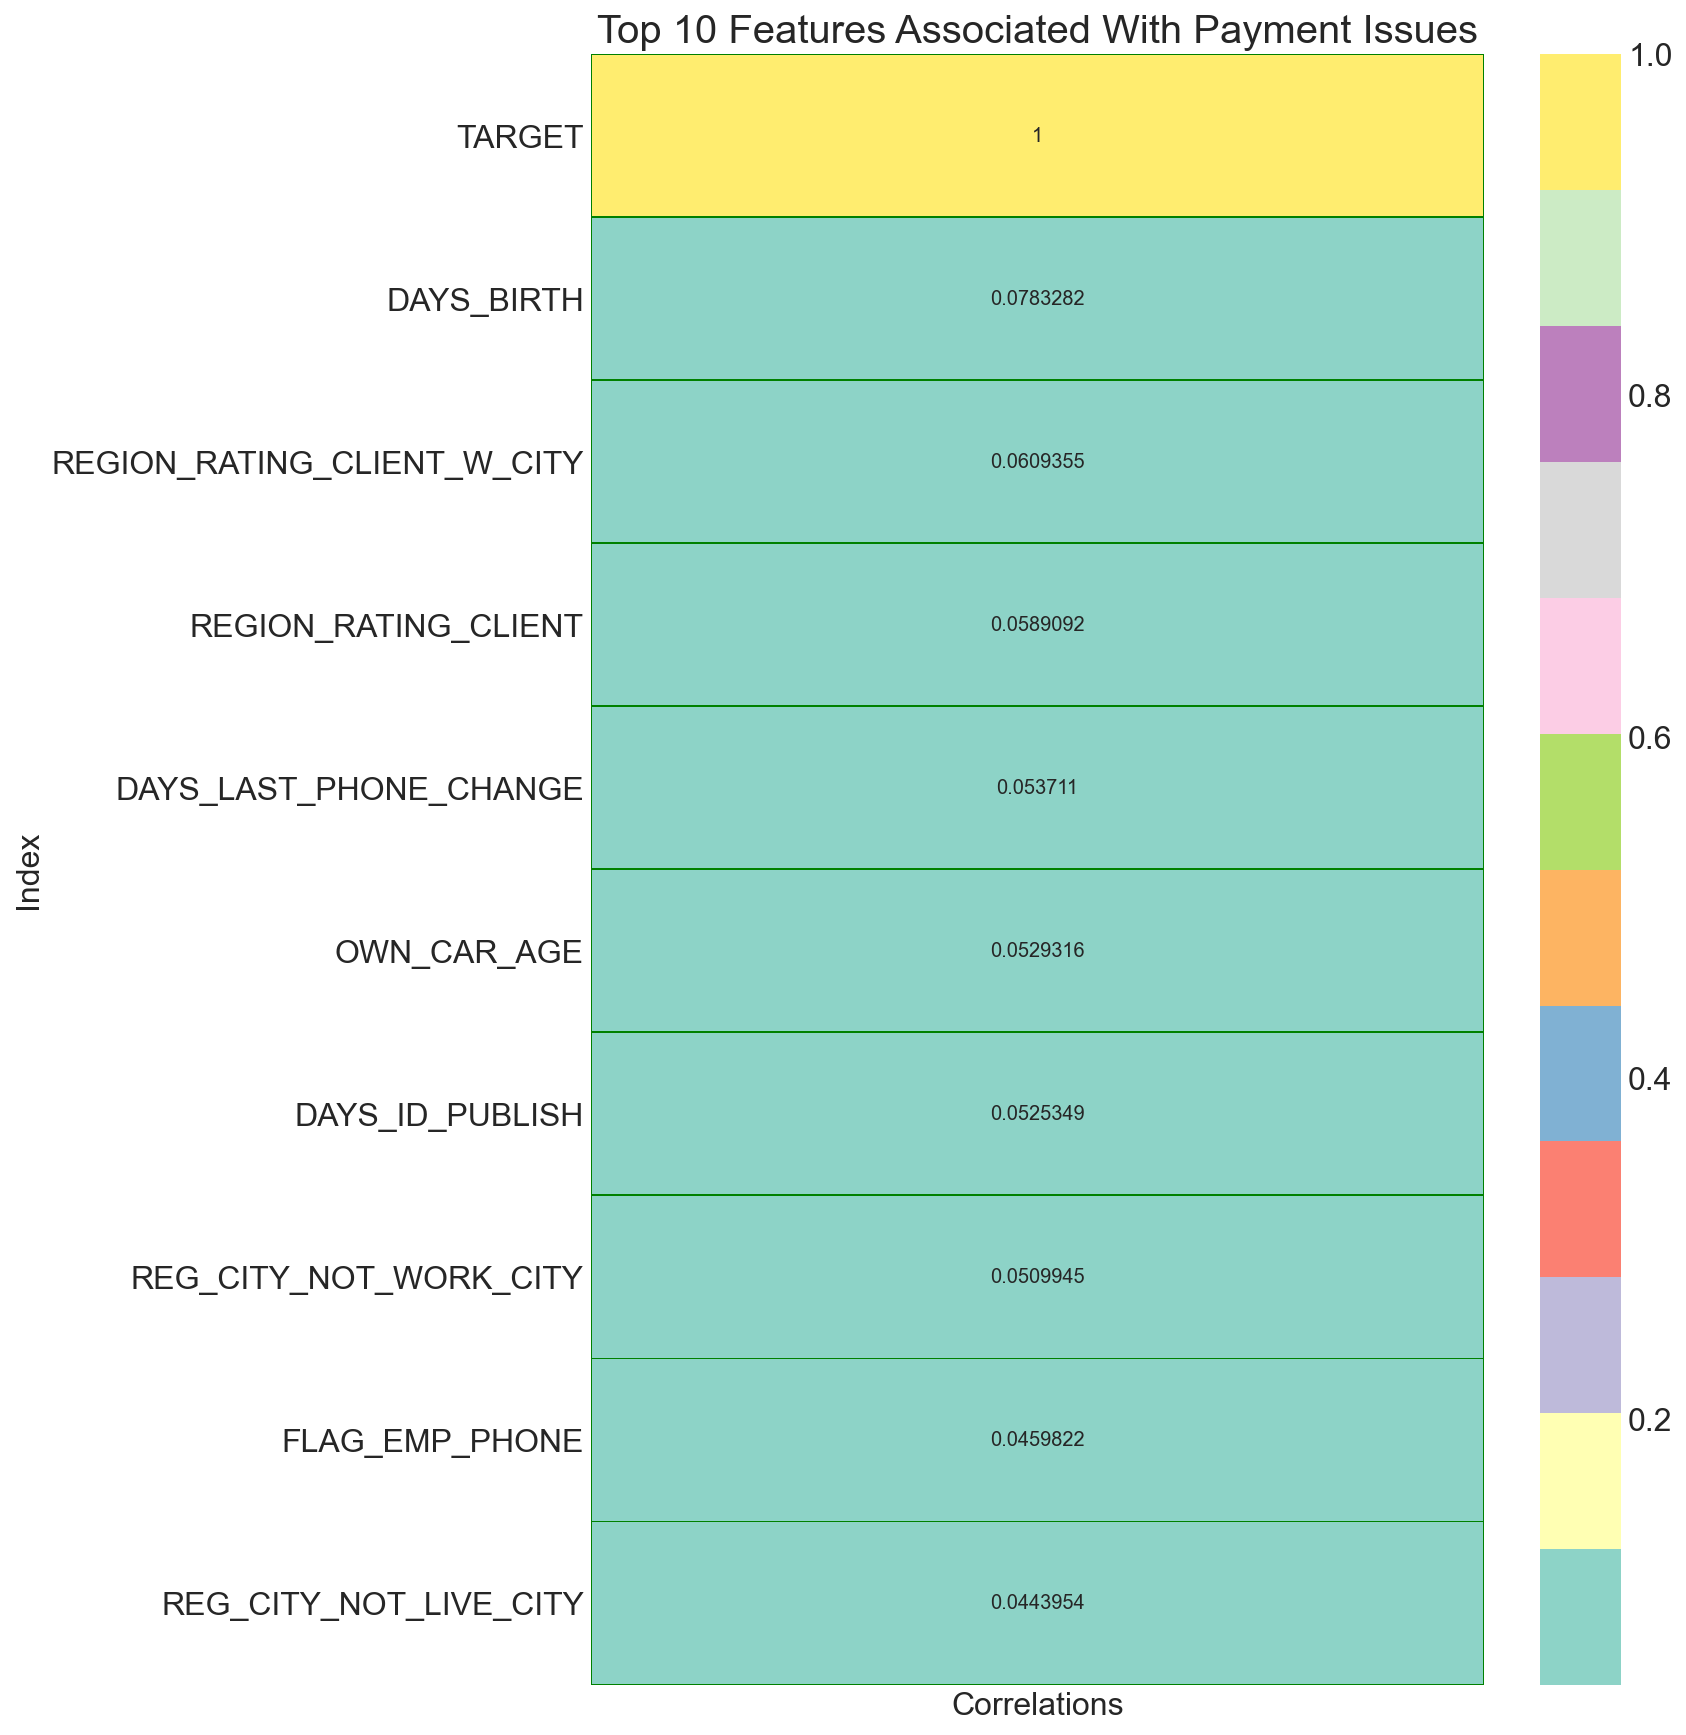

In [16]:
issue_corr = df['TARGET'] == 1
corr = df.corrwith(issue_corr,method='spearman').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(10)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Top 10 Features Associated With Payment Issues", fontsize=20)
plt.show()

In [17]:
# check correlation of features with the target variable
corr_matrix = df.corr().abs()
print(corr_matrix['TARGET'].sort_values(ascending=False).head(10))
# Comment: We only check the correlations of the features with the target [Why?]. [What is the "learning"?]

TARGET                         1.000000
EXT_SOURCE_3                   0.178918
EXT_SOURCE_2                   0.160471
EXT_SOURCE_1                   0.155318
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64



The top 3 features correlated with payment issues are the age of the client and the region rating with and without taking the home city into account. The days since the last phone change was the 4th largest correlation with payment issues.

#### 2.5. Distribution of Target Columns


The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [18]:
# distribution of target column
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

#### 2.6. Data Imbalance

No handles with labels found to put in legend.


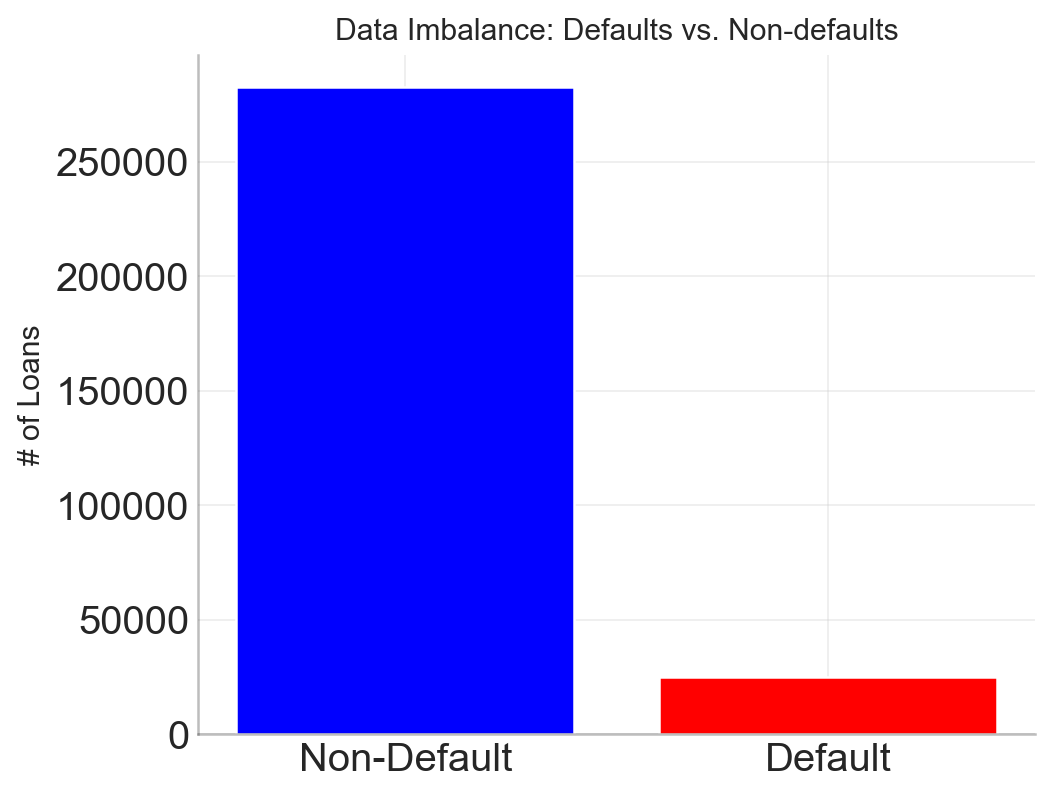

In [19]:
# @hidden
plt.figure(figsize=(6,5), dpi= 90)
x_values = [0, 1]
labels = ['Non-Default', 'Default']
gender_dist = df.groupby('TARGET').apply(lambda x:x['SK_ID_CURR'].count()).reset_index(name='Counts')
plt.bar(gender_dist['TARGET'], gender_dist['Counts'],color='br')
plt.ylabel('# of Loans',size=12)
plt.title('Data Imbalance: Defaults vs. Non-defaults',size=12)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)
plt.legend()
plt.xticks(x_values, labels)
plt.show();

From this information, we see that this is an imbalanced class problem. There are way more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

#### 2.7. Distribution of loan types

In [20]:
# distribution of loan types
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = df[feature].value_counts()
    df3 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,6))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df3)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

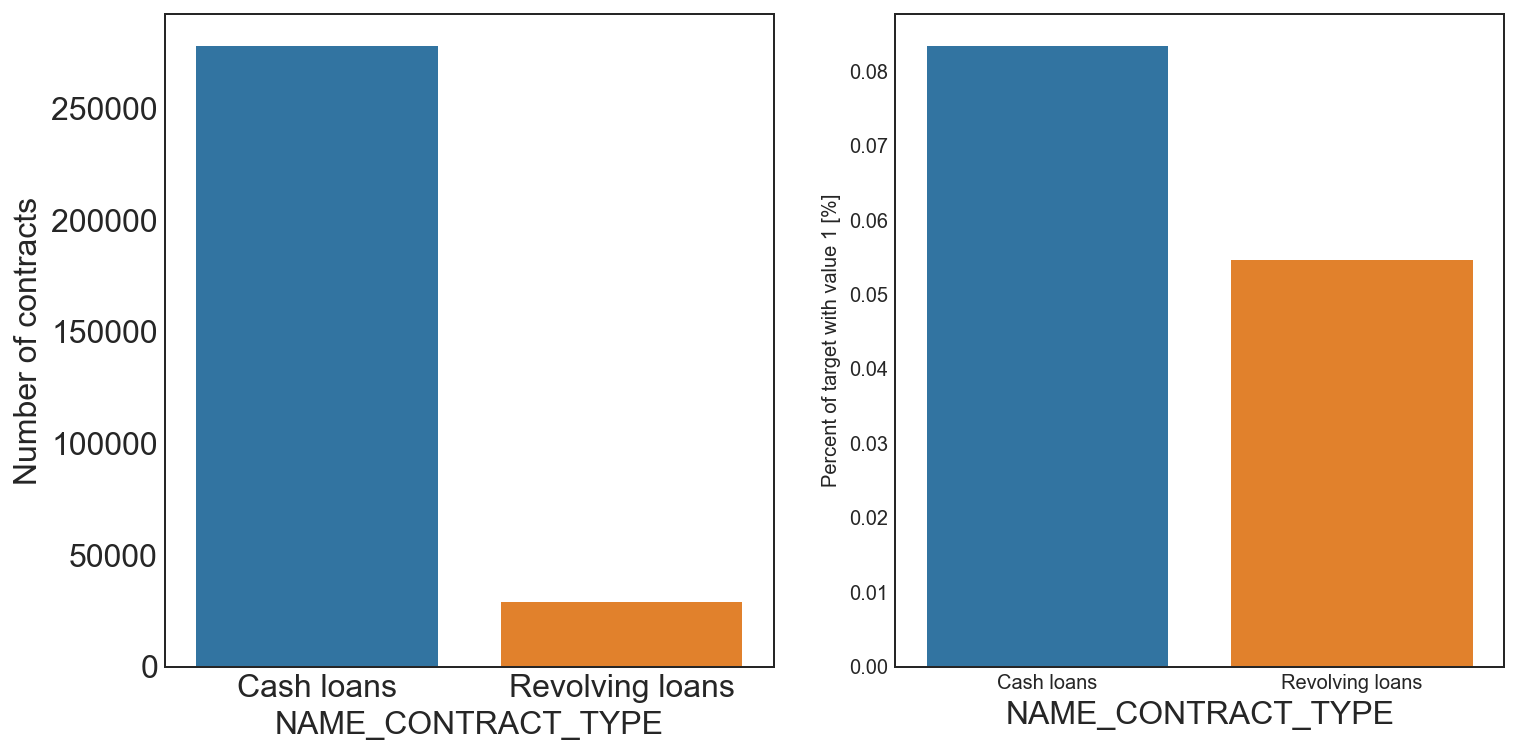

In [21]:
plot_stats('NAME_CONTRACT_TYPE')


Contract type 'Revolving loans' are just a small fraction (10%) from the total number of loans; at the same time, a larger amount of revolving loans, comparing with their frequency, are not repaid.

#### 2.8. Income Ranges of All Applicants by Loan Type

In [22]:
# The total income value will be split b/w 5 categories to make it easier to use
df['INCOME_VAL'] = pd.cut(df.AMT_INCOME_TOTAL, bins=[0,50000,150000,300000,500000,1000000], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

In [23]:
df['INCOME_VAL'].value_counts()

Low          150772
Medium       129483
High          20037
Very Low       4517
Very High      2452
Name: INCOME_VAL, dtype: int64

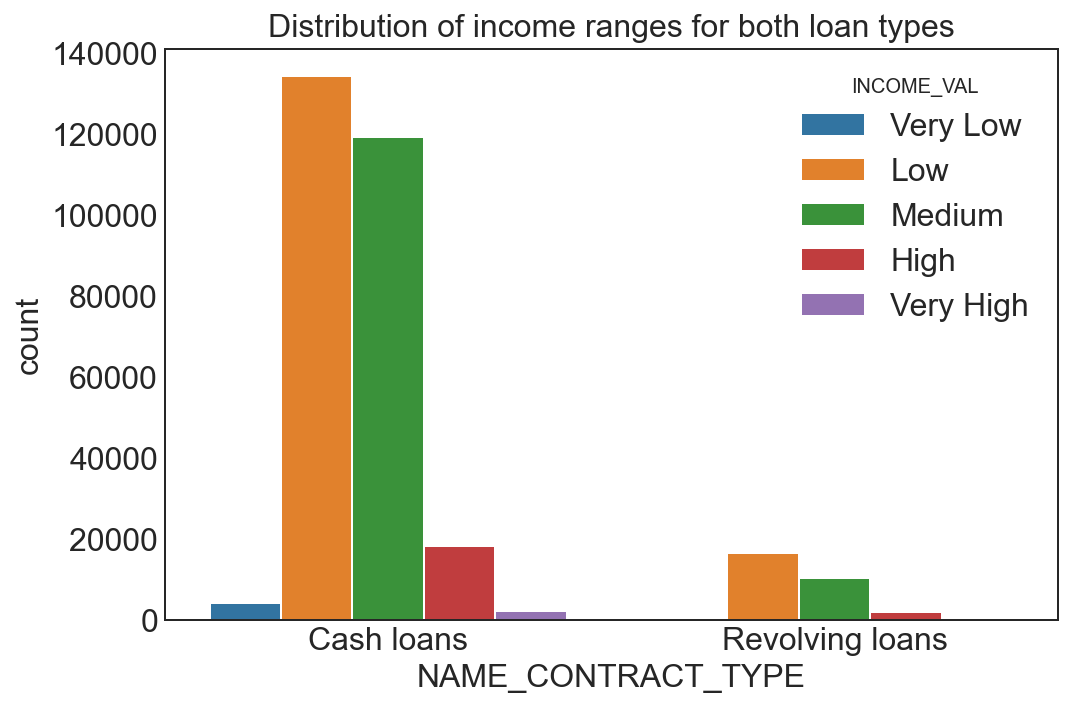

In [24]:
plt.figure(figsize=(8,5.25))
ax_1 = sns.countplot(x='NAME_CONTRACT_TYPE', hue='INCOME_VAL', data= df)
plt.title('Distribution of income ranges for both loan types')
plt.show()

#### 2.9. Distribution of Client Gender and Age

In [25]:
#Converting the values in columns starting with 'DAYS' to absolute
df['DAYS_BIRTH']= abs(df['DAYS_BIRTH'])

In [26]:
print(df.DAYS_BIRTH.unique())

[ 9461 16765 19046 ...  7951  7857 25061]


In [27]:
# Days_birth column has the age of the client in days and the datatype is float
# Converting the age to years and the datatype to int
df.DAYS_BIRTH = ((df.DAYS_BIRTH)/365).astype('int')
df.DAYS_BIRTH.describe()

count    307511.000000
mean         43.435968
std          11.954593
min          20.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          69.000000
Name: DAYS_BIRTH, dtype: float64

In [28]:
#Let's bin the birth data to make it easier to use.
df['DAYS_BIRTH_BINS']=pd.cut(df.DAYS_BIRTH, bins=[18,40,60,100], labels=['Young','Middle_Age','Senior'])
df['DAYS_BIRTH_BINS'].value_counts()

Middle_Age    142220
Young         135923
Senior         29368
Name: DAYS_BIRTH_BINS, dtype: int64

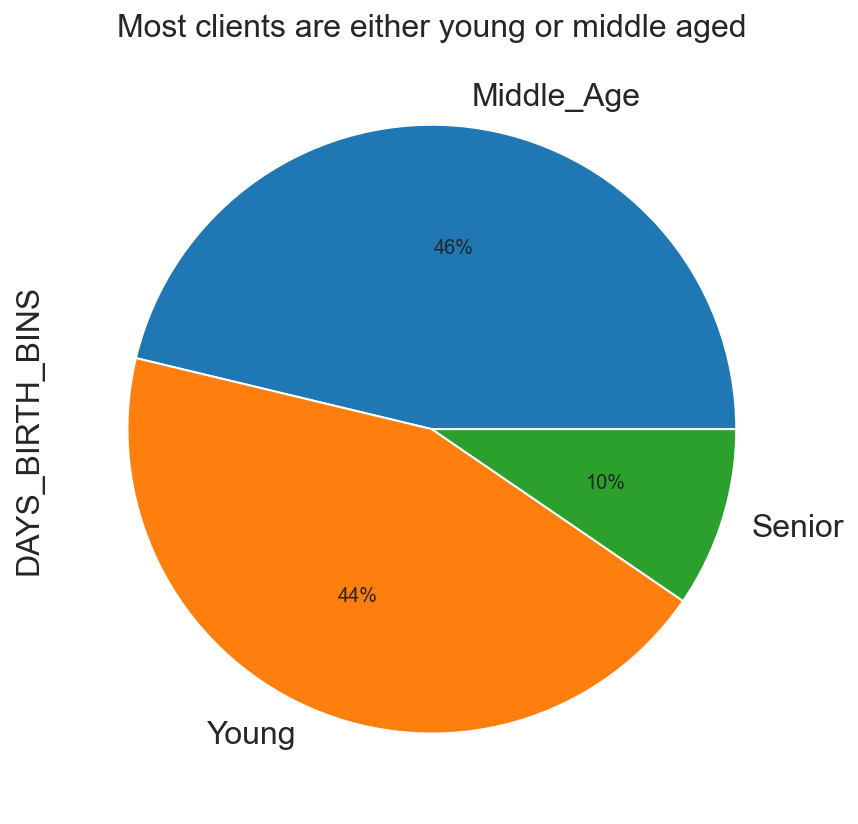

In [29]:
fig =plt.subplots(1,1,figsize=[15,10])
plt.subplot(1,2,1)

df.DAYS_BIRTH_BINS.value_counts().plot.pie(autopct='%1.0f%%')
plt.title('Most clients are either young or middle aged')
plt.show()

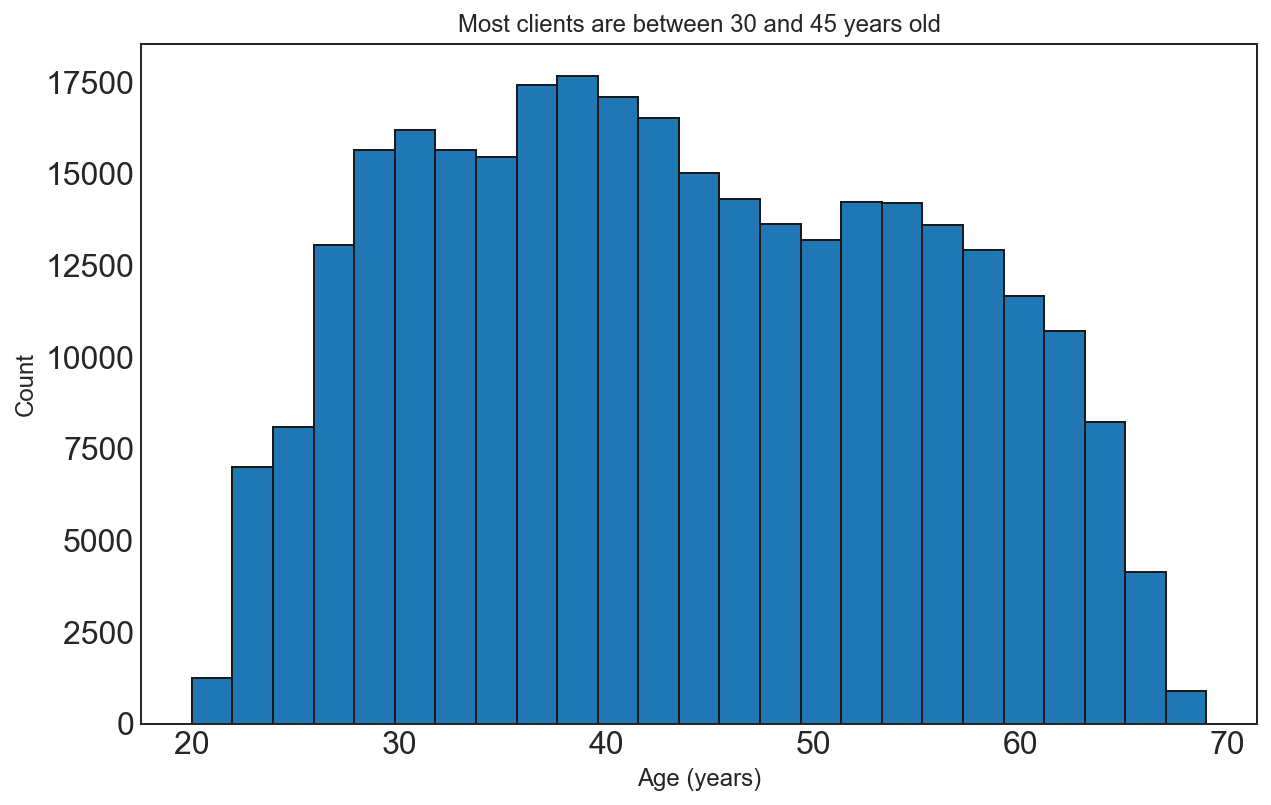

In [30]:
plt.figure(figsize=(10,6.25))
plt.hist(df['DAYS_BIRTH'], edgecolor='k',bins=25)
plt.title('Most clients are between 30 and 45 years old', fontsize = 12)
plt.xlabel('Age (years)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

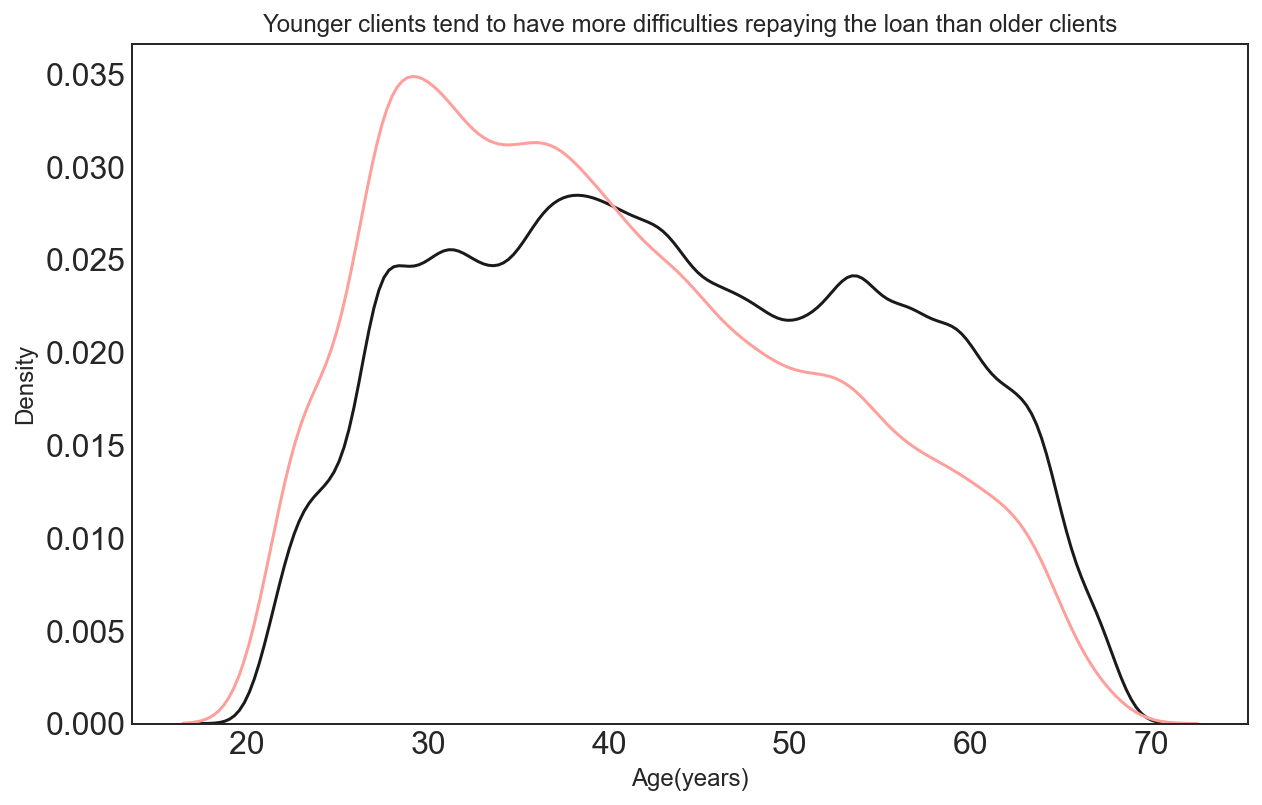

In [31]:
plt.figure(figsize=(10,6.25))

# (TARGET=0)
sns.kdeplot(df.loc[df['TARGET']==0,'DAYS_BIRTH'],label='target==0', color = 'k')

# (TARGET=1)
sns.kdeplot(df.loc[df['TARGET']==1,'DAYS_BIRTH'],label='target==1', color = 'r')

plt.xlabel('Age(years)', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.title('Younger clients tend to have more difficulties repaying the loan than older clients', fontsize = 12)

plt.show()

#### 2.10. Failure to Repay by Age Group

In [32]:
np.linspace(20,70,num=11)

array([20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.])

In [33]:
age_data=df[['TARGET','DAYS_BIRTH']]

# Bin the age data
age_data['YEARS_BINNED']=pd.cut(age_data['DAYS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BINNED
0,1,25,"(20.0, 25.0]"
1,0,45,"(40.0, 45.0]"
2,0,52,"(50.0, 55.0]"
3,0,52,"(50.0, 55.0]"
4,0,54,"(50.0, 55.0]"
5,0,46,"(45.0, 50.0]"
6,0,37,"(35.0, 40.0]"
7,0,51,"(50.0, 55.0]"
8,0,55,"(50.0, 55.0]"
9,0,39,"(35.0, 40.0]"


In [34]:
# Group by the bin and calculate averages

age_groups  = age_data.groupby('YEARS_BINNED').mean()

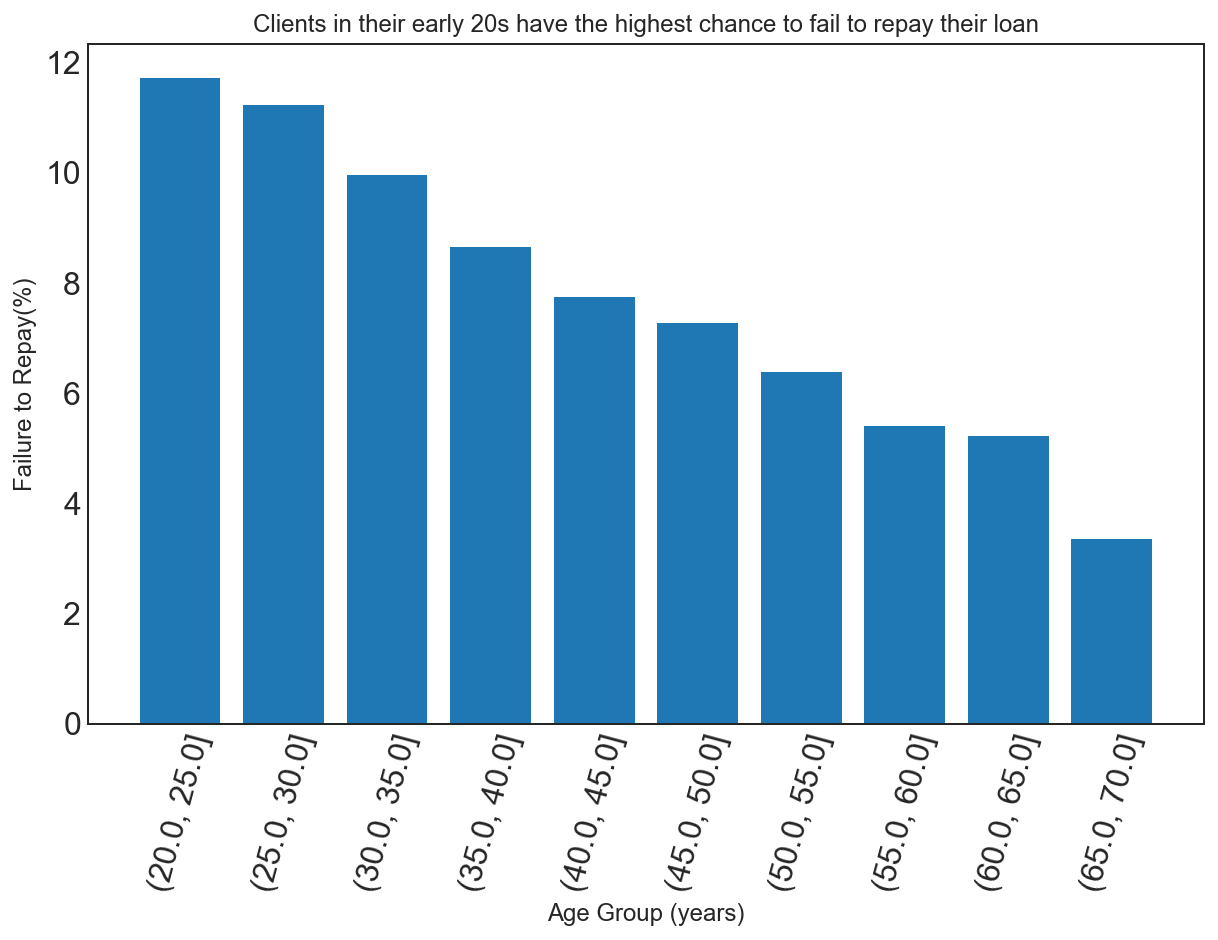

In [35]:
plt.figure(figsize=(10,6.25))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)', fontsize = 12)
plt.ylabel('Failure to Repay(%)', fontsize = 12)
plt.title('Clients in their early 20s have the highest chance to fail to repay their loan', fontsize = 12)

plt.show()

#### 2.11. Clients' Family Background

**Family Status**

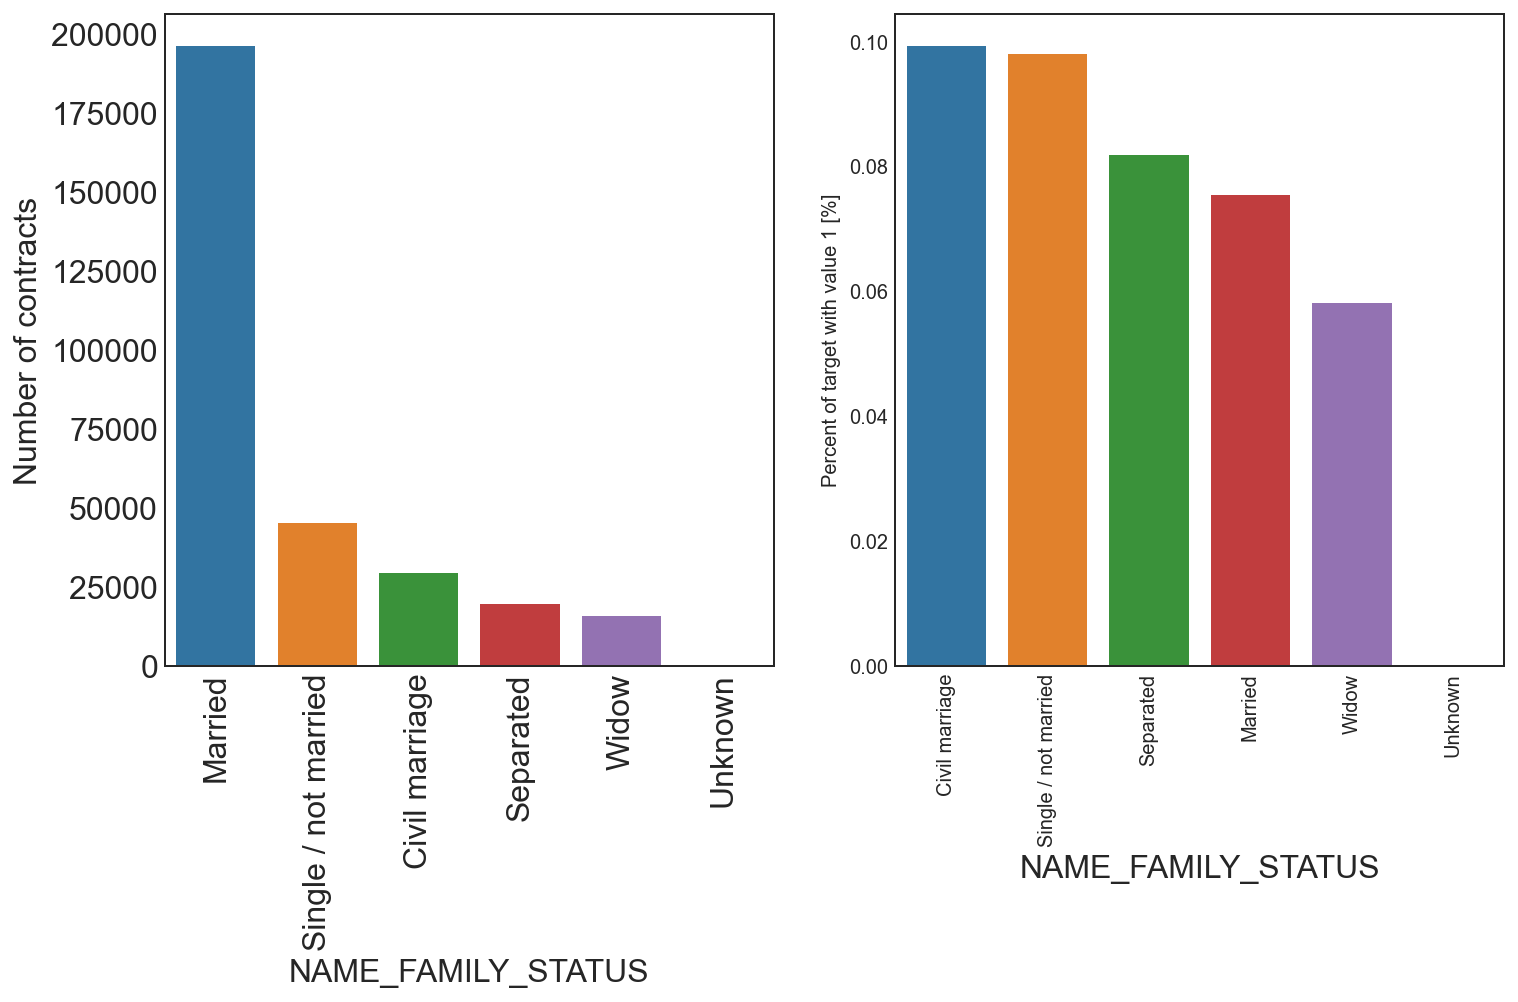

In [36]:
plot_stats('NAME_FAMILY_STATUS',True, True)


Most of clients are married, followed by single/not married and civil marriage. Clients in civil marriage make up the highest percentage (10%) of all clients that didn't repay their loan, while clients with status 'Widow' rank lowest (exception being 'Unknown').

**Number of Children**

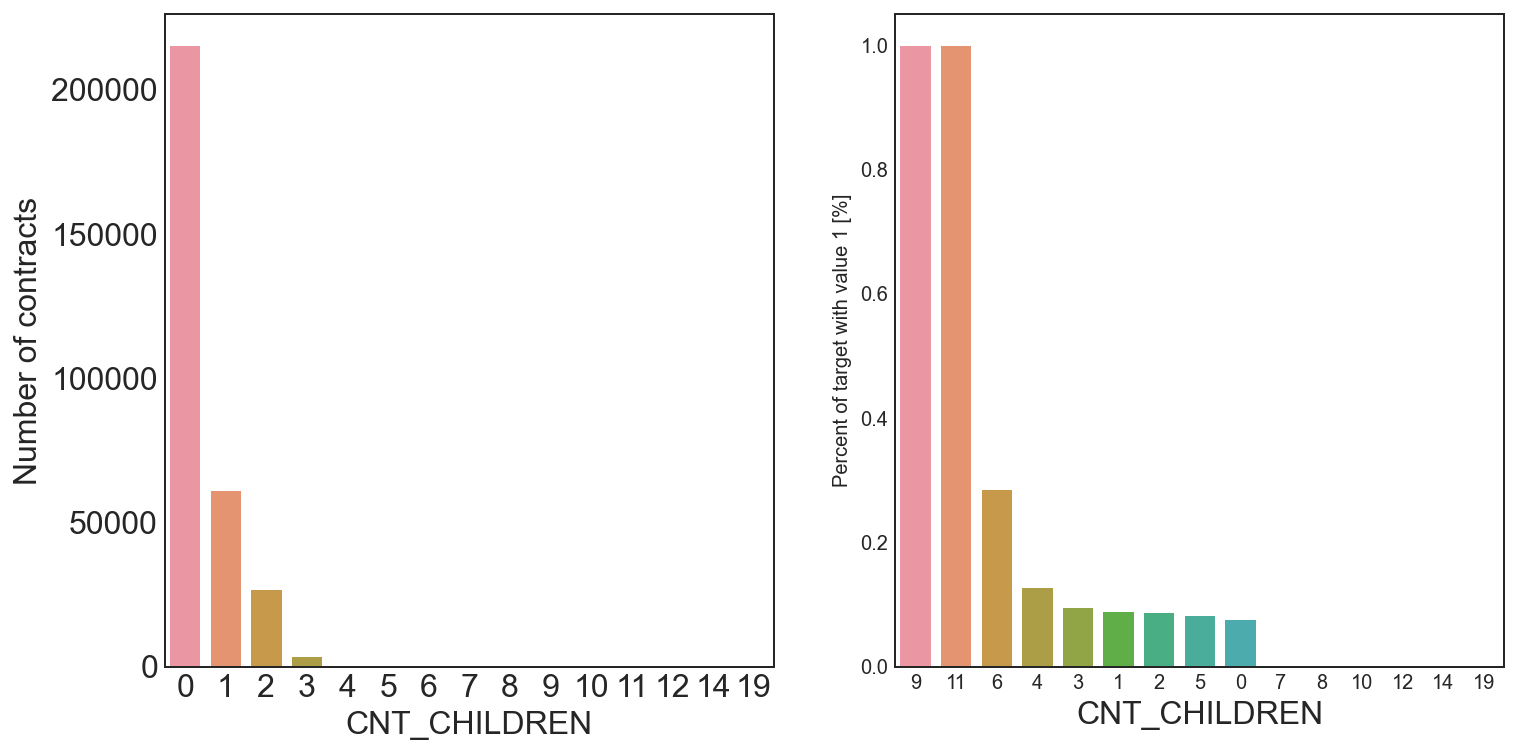

In [37]:
plot_stats('CNT_CHILDREN')

Most of the clients taking a loan have no children. Compared with this number, the number of loans associated with the clients with one child is 4 times smaller, the number of loans associated with the clients with two children is 8 times smaller; clients with 3, 4 or more children are much more rare. As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children). As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

**Family Members**

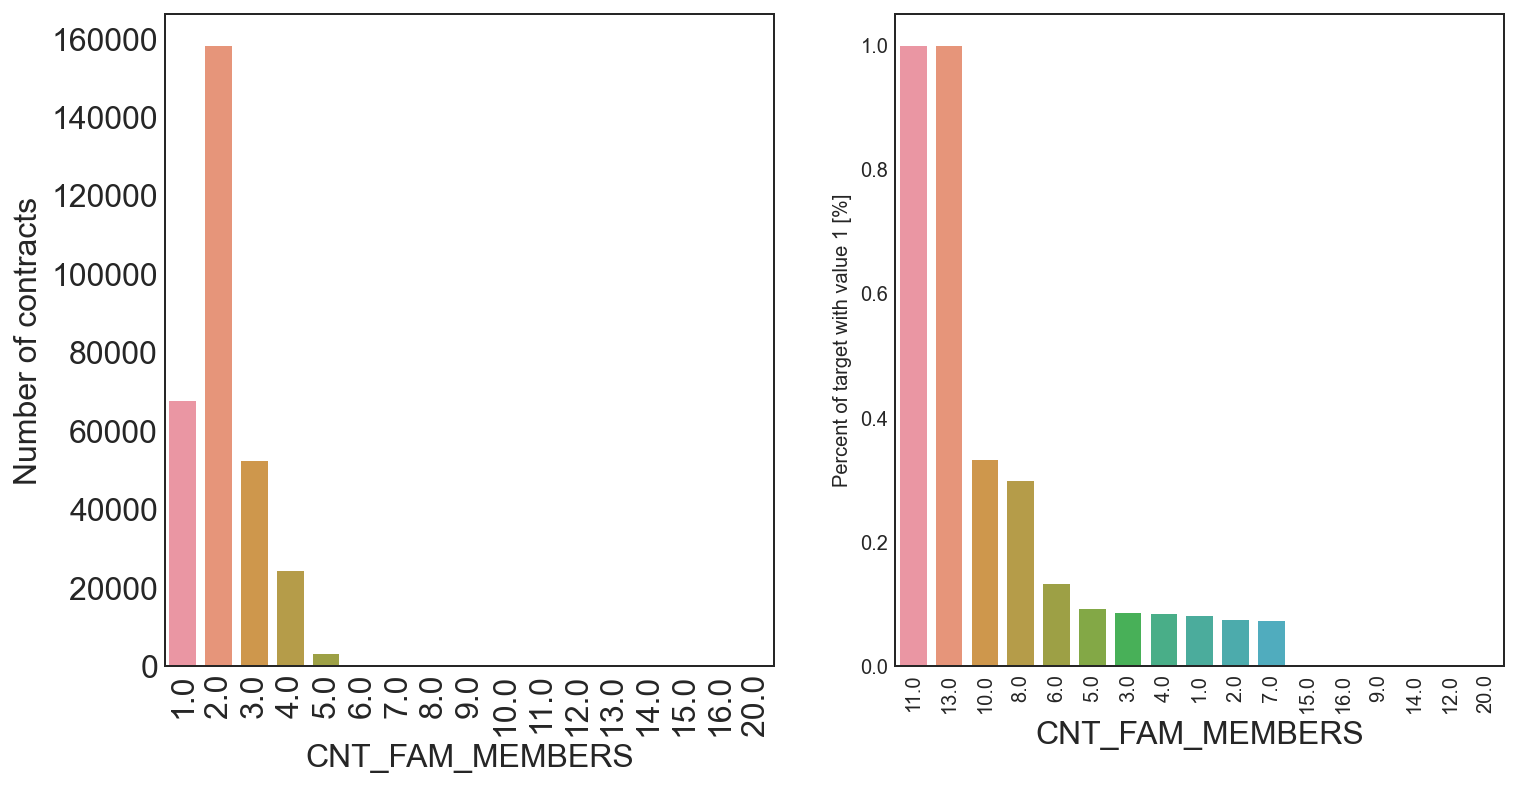

In [38]:
plot_stats('CNT_FAM_MEMBERS',True)


Clients with 2 family members are most common, followed by 1 (single persons), 3 (families with one child) and 4. 100% of clients with family size of 11 and 13 do not repay their loan. Other families with 10 or 8 members show percentages of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.

#### 2.12. Income Ranges

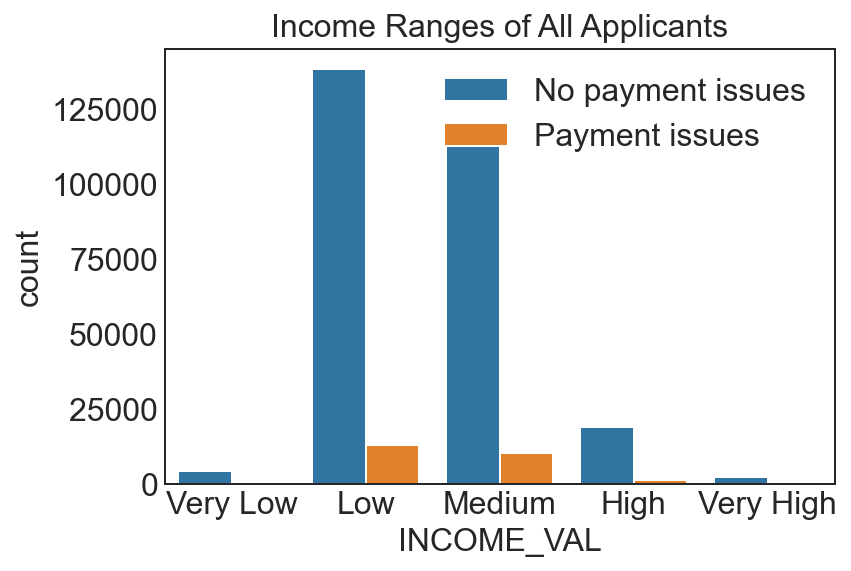

In [39]:
ax_2 = sns.countplot(x='INCOME_VAL', hue='TARGET', data= df)
plt.title('Income Ranges of All Applicants')
ax_2.legend(['No payment issues','Payment issues'])
plt.show()

We can see in this barplot that most borrowers fall into the Medium and Low income ranges. This paints a picture as to who is seeking out loans. It makes sense that those on the extremes of the income spectrum would either be unable to secure a loan or not need to secure a loan at all.

#### 2.13. Educational Background

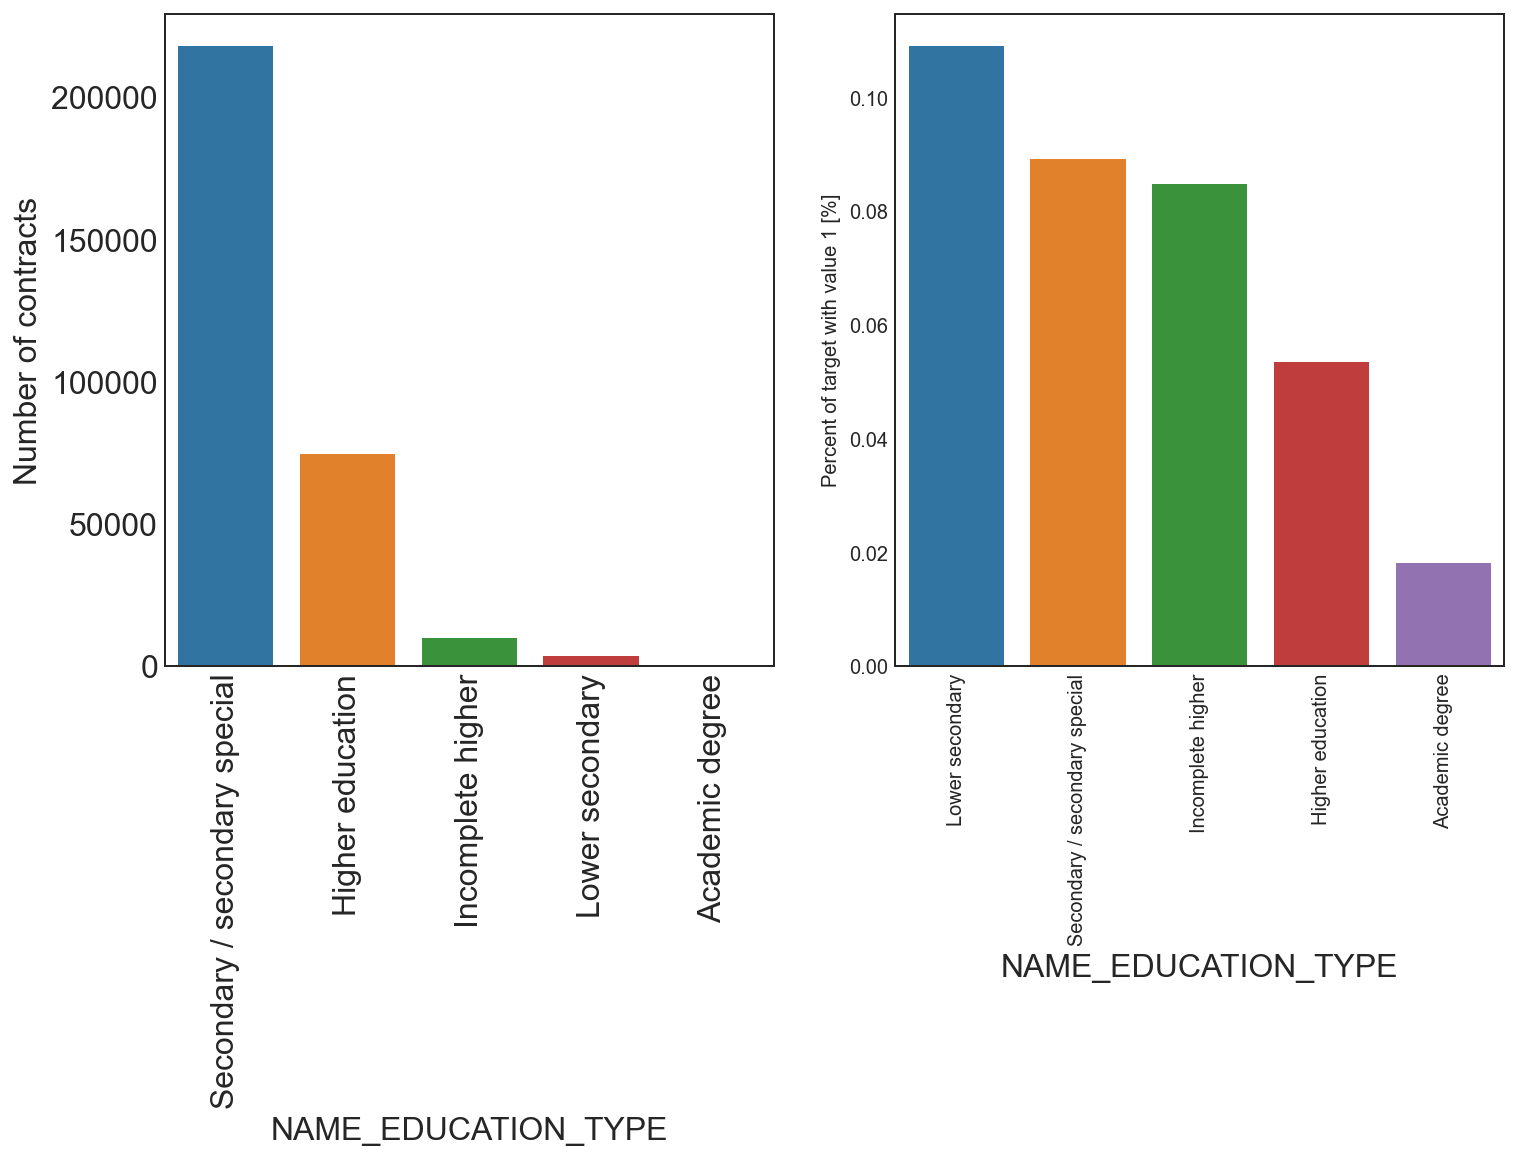

In [40]:
plot_stats('NAME_EDUCATION_TYPE',True)


Majority of the clients have secondary or secondary special education, followed by clients with higher education. Only a very small number of clients having an academic degree. The lower secondary category, although rare, have the largest rate of not returning the loan (11%). Clients with academic degree have less than 2% not-repayment rate.

#### 2.14. Clients' Occupation

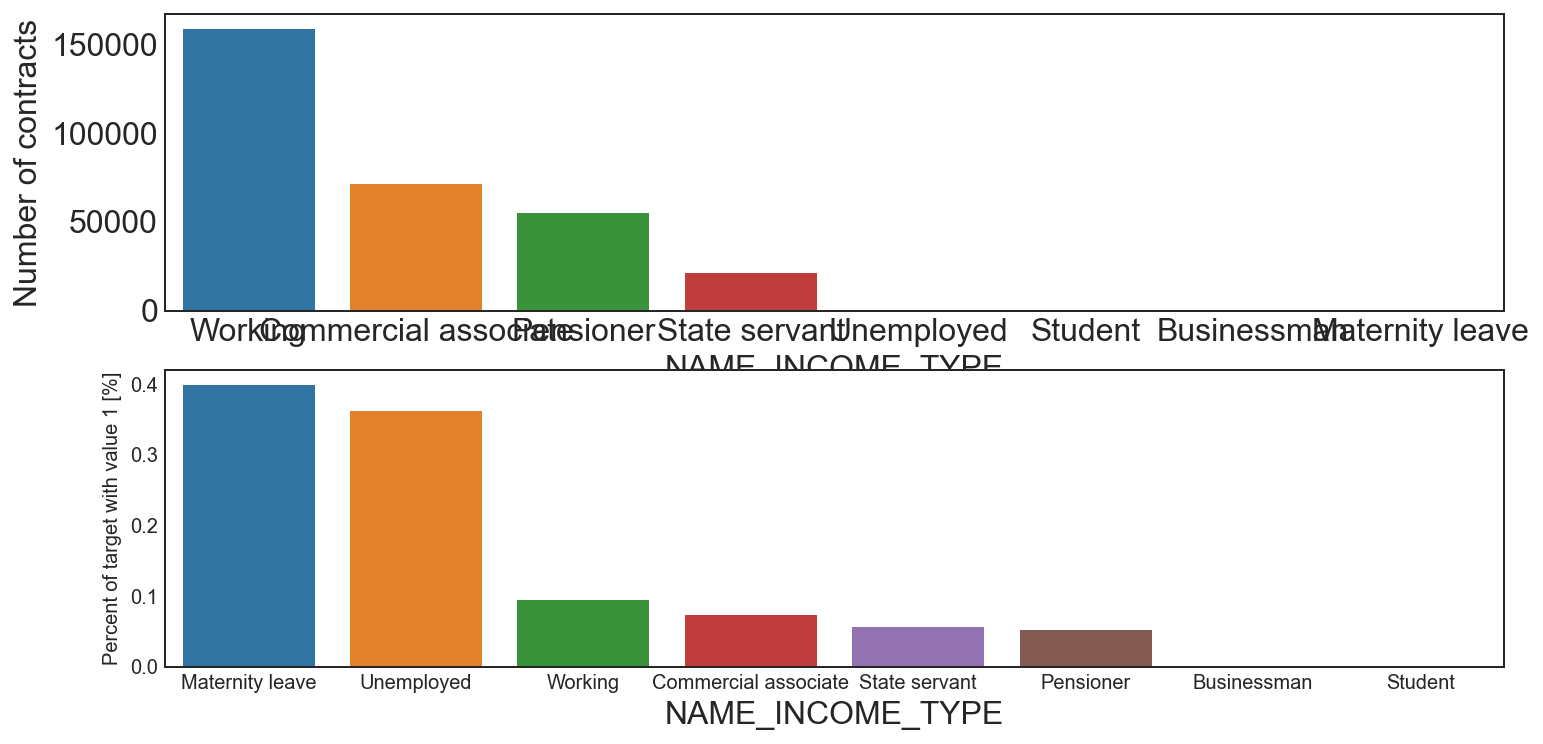

In [41]:
# Income type of client and percent of not returned loans per income type of applicants.
plot_stats('NAME_INCOME_TYPE',False,False)


Most applicants for loans earn income from Working, followed by Commercial associate, Pensioner and State servant. The applicants on maternity leave show almost 40% ratio of not returning loans, followed by unemployed people (37%). The remaining income types are located under the average of 10% for not returning loans.

#### 2.15. Occupation Type

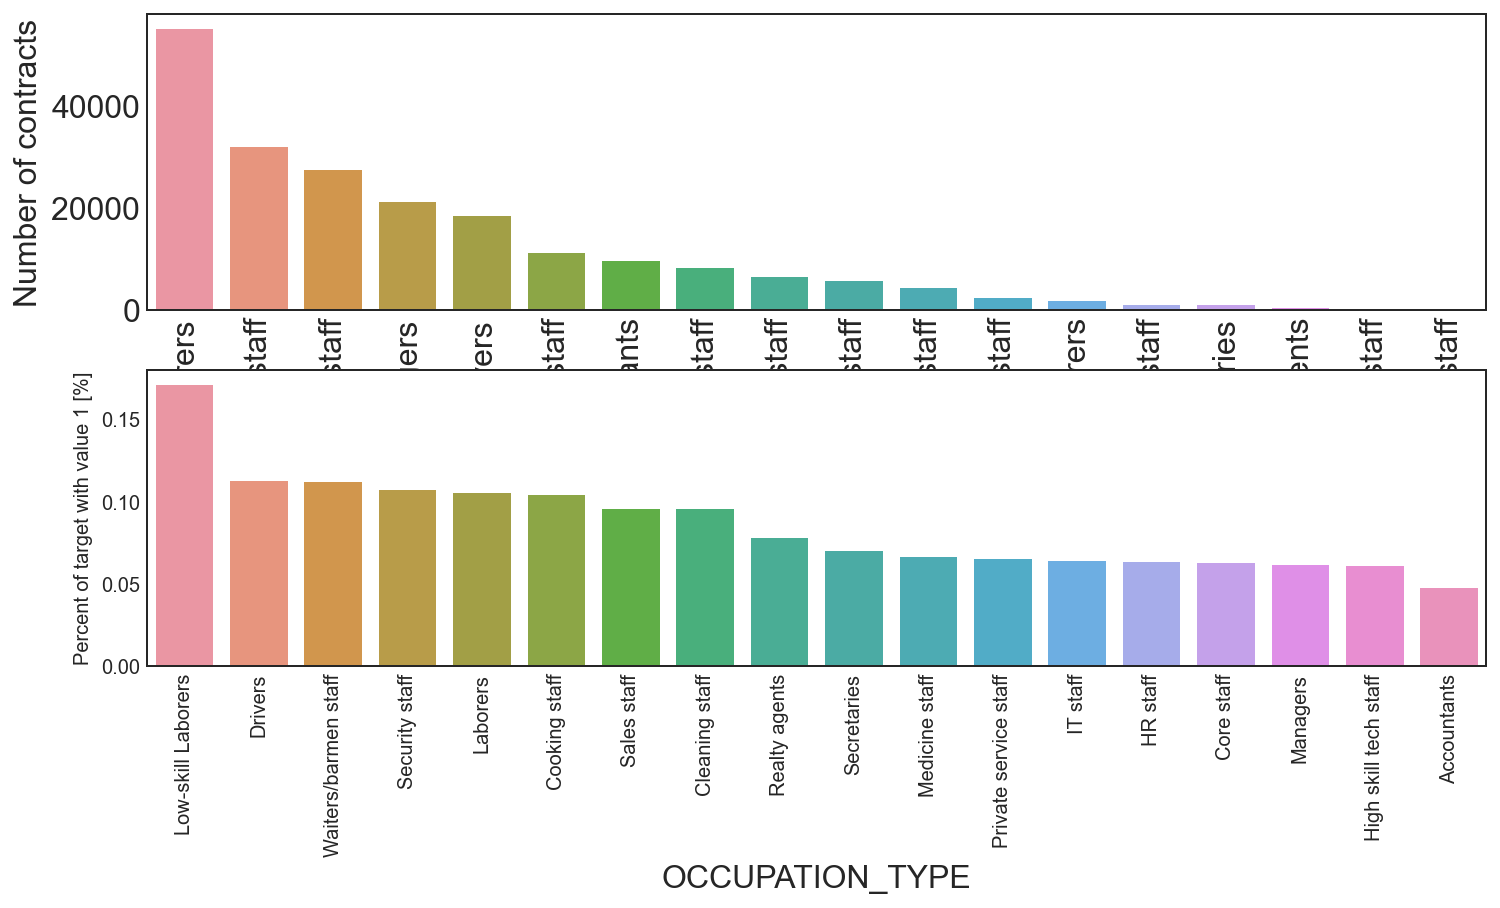

In [42]:
plot_stats('OCCUPATION_TYPE',True, False)


Most of the loans are taken by Laborers, followed by Sales staff. IT staff take the lowest amount of loans. The category with highest percentage of not repaying loans are low-skilled laborers (above 17%), followed by drivers and waiters/barmen staff, security staff, laborers and cooking staff.

#### 2.16. Distribution of AMT_CREDIT (outlier detection)

AMT_CREDIT is the amount of money the client applied to loan from Home Credit. Given that this is one of the most important features in our dataset, the group thought that outliers in this column will might effect the prediction negatively. The outlier removal is done in later sections of this notebook.

In [43]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def plot_b_o_distribution(df, feature, color): 
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    x = df[feature].dropna() 
    filtered = x[~is_outlier(x)] 
    sns.distplot(filtered,color=color, kde=True,bins=100) 
    plt.show()

In [44]:
plot_b_o_distribution(df_after, 'AMT_CREDIT', 'blue')

NameError: name 'df_after' is not defined

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

#### 2.17. Summary

What have we learned from exploring this data set? We learned what the borrowers look like socio-economically. Most borrowers are ranged from lower to middle income and have secondary education. These borrowers are more likely to be married or be in a relationship at the time of securing the loan. Cash loans are the most popular loan type, favored by the lower and middle class earners. Most loans are given to middle-aged or younger people. The correlations with payment issues brought interesting things to light. The top 3 correlations involved age and region ratings of the applicants.

### 3. Data Processing

Data processing is a crucial step in building machine learning algorithms, on which data scientists spent on average as much as 80% of their time. The purpose is to transform the original dataset and ensure compatibility with the chosen machine learning algorithms. On a further note, this will improve also their performance resulting in more accurate modelling. 

We will focus on finding and handling missing values, dealing with multicollinearity, analyze the cardinality of non-numeric features in the dataset.

#### 3.1. Missing values in the datasets

To begin with, we analyze our entire dataset on missing values by creating a dataframe that holds absolute and relative quantities of missing values per column.

In [45]:
# @hidden
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1))

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [46]:
table_missing_features = missing_values_table(df)
table_missing_features.head(10)

Your selected dataframe has 124 columns.
There are 68 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


#### 3.2. Missing value handling

When having missing values in a feature, we face a tradeoff between the risk of losing a meaningful feature for our model that has a lot of missing data and inaccurate representation of the feature by imputing a large percentage of the feature's values. Usually, features that have more than 20-30% of missing data should be discarded, however, you should think about the relevance of each feature that is being dropped beforehand. As we face 122 features that are fairly complex to evaluate, we choose a higher threshold of 50%, this way accounting for the fact that we may drop features that are important but have a lot of missing data. We will use imputation to fill in the values where necessary at a later stage.

In [47]:
# @hidden
missing_values = missing_values_table(df).reset_index()
missing_values_cols = missing_values[missing_values['Missing Values'] > 50]
missing_values_cols = missing_values_cols['index'].to_list()

# drop columns where NaN > 50%
df_after = df.drop(missing_values_cols, axis = 1)
print ('Dataset before deletion of missing values: {}'.format(df.shape))
print ('Dataset after deletion of missing values: {}'.format(df_after.shape))

Your selected dataframe has 124 columns.
There are 68 columns that have missing values.
Dataset before deletion of missing values: (307511, 124)
Dataset after deletion of missing values: (307511, 59)


Out of the 122 features, 67 columns have at least 1 missing value. However, as we set our threshold to 50% not all missing value columns are dropped - in fact, we only drop 64 columns (122-58) leaving 58 features, which will be imputed at a later stage.

#### 3.3. Remove collinear features based on threshold

Collinearity occurs when two features show a linear assocaition between each other. This implies that they roughly yield the same information and keeping both of them, does not add predictive power for our model. When features are highly correlated, generally, with a coefficient higher than 0.7, the generalization performance and interpretability of the established model decreases, which is why we want to avoid multicollinearity. We will remove features that have a correlation coefficient of 0.9 or higher to focus on only the strongest correlations.

In [48]:
# @hidden
df_before_drop = df_after.copy()
correlated_features = set()
correlation_matrix = df_after.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
#These are the features that will be dropped.
df_after.drop(labels=correlated_features, axis=1, inplace=True)
print ('Dataset before dropping collinear-features: {}'.format(df_before_drop.shape))
print ('Dataset after dropping collinear-features: {}'. format(df_after.shape))

Dataset before dropping collinear-features: (307511, 59)
Dataset after dropping collinear-features: (307511, 57)


The 58 features that were left over after handling missing values, are reduced to 56 features. This means that only 2 features showed high correlation of above 90%, potentially causing a multicollinearity problem.

#### 3.4. Cardinality of the non-numeric features

Cardinality refers to the set of unique values that a categorical feature can take on. We will find the cardinality for our remaining 56 features.

In [49]:
# @hidden
# selecting all columns that have categorical data and computing their unique set of values
def get_cardinality (df):
    object_columns = (df.select_dtypes(include="object").columns)
    for column in object_columns:
        print("{} has {} unique values.".format(column, df[column].nunique()))
get_cardinality(df_after)

NAME_CONTRACT_TYPE has 2 unique values.
CODE_GENDER has 3 unique values.
FLAG_OWN_CAR has 2 unique values.
FLAG_OWN_REALTY has 2 unique values.
NAME_INCOME_TYPE has 8 unique values.
NAME_EDUCATION_TYPE has 5 unique values.
NAME_FAMILY_STATUS has 6 unique values.
NAME_HOUSING_TYPE has 6 unique values.
WEEKDAY_APPR_PROCESS_START has 7 unique values.
ORGANIZATION_TYPE has 58 unique values.


Out of our 58 features, 10 features are categorical and are checked on the number of distinct values.

We can infer that a feature has a<br>
- high cardinality if it has more than 8 distinct values: like ORGANIZATION_TYPE
- moderate cardinality if it has more than 5 rows: like NAME_INCOME_TYPE and NAME_EDUCATION TYPE
- low cardinality if it has less than 5 rows: NAME_CONTRACT_TYPE and CODE_GENDER

We want to avoid having high cardinality features in our dataset as this may cause problems in training our models. The more distinct values a categorical variable can take on, the more features will be created when transforming them for example with one-hot encoding. Thus, high cardinality may lead to an explosion of features, which could slow down the computation time tremendously. Also, high cardinality may bring the curse of dimensionality, which means that data becomes more sparse as there is a higher chance that an instance is unique.

However, in our case, we can assume that we do not face problems through high cardinality as only one out of 57 features has high cardinality, which we are willing to accept in terms of computation time. All other non-numerical features show an appropriate number of distinct values. This will keep down the number of features created in the transformation step.

#### 3.5 Preliminary Results

The first two steps included loading and describing the dataset. In this step we adjusted for missing values and collinearity of features, while we also checked for high cardinality of non-numerical features. We reduced our features that will be used for modelling from 122 to only 57.

### 4. Feature Engineering

In this step we will focus on selecting only the features that are important to our problem at hand, while discarding irrelevant ones. Also we will split the dataset used into training and test set such that we can use a pre-processing pipeline to transform our features. This involves imputing missing data for categorical and numerical features as well as scaling them.

#### 4.1. Outlier Detection based on modified z-score

Continuing with the previous work done in 2.16, we are deleting here all outliers which might appear in the ***AMT_CREDIT*** column. This is achieved by using modified z-score. Knowing that our data is roughly normally distributed, we could use the z-score method, by which we would consider points to be outliers based on how much they deviate from the mean value, however, the mean is not a robust statistic. It is heavily influenced by outliers, meaning that the outliers we are trying to detect would affect the method itself. The median for instance is a robust statistic, meaning it will not be greatly affected by outliers. This is called the ***modified z-score*** method, and instead of using standard deviation, it uses the MAD (Median Absolute Deviation).

Here we are going to make a slight modification and introduce a consistency correction k , which allows us to use MAD as a consistent estimate for the standard deviation. The value of k depends on the underlying distribution of the data. For simplicity, we will use the value for a normal distribution k = 1.4826 (see https://en.wikipedia.org/wiki/Median_absolute_deviation) [8].

In [50]:
# https://www.kaggle.com/jainyk/anomaly-detection-using-zscore-and-modified-zscore
def modified_zscore(data, consistency_correction=1.4826):
    median = np.median(data)
    deviation_from_med = np.array(data) - median
    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

mod_zscore_goals, mad_goals = modified_zscore(df_after['AMT_CREDIT'])
outlier_credits = df_after.assign(mod_zscore = mod_zscore_goals)

In [51]:
print ('Dataset before deleting outliers: {}'.format(df_after.shape))
mod_zscore_anomalies_credit = outlier_credits[(outlier_credits['mod_zscore'] > 3)]
b_index = mod_zscore_anomalies_credit.set_index(['SK_ID_CURR']).index
a_index = df_after.set_index(['SK_ID_CURR']).index
mask = ~a_index.isin(b_index)
df_after = df_after.loc[mask]
print ('Dataset after deleting outliers: {}'.format(df_after.shape))

Dataset before deleting outliers: (307511, 57)
Dataset after deleting outliers: (301072, 57)


#### 4.2. Reduce rows by taking a sample from the original dataset

We tried to run the ML-models in section 5 with the full dataset (307511 rows, 124 columns), however, we constantly got an "out of memory error". Thus, we reduce our dataset by half by taking a stratified-sample, which divides the dataset into heterogenous subgroups that are sharing the same characteristic (default or non-default). Next, every subgroup or strata, is sampled randomly, which means that we are keeping the same balance between defaults and non-defaults but only reduce the size of our dataset.

In [52]:
# @ hidden
# compute distributions of defaults & non-defaults of original dataframe
non_defaults_original = df_after.TARGET.value_counts()[0]
defaults_original = df_after.TARGET.value_counts()[1]
combined_original = df_after.shape[0]
print ('Non-Defaults in original dataset: {}'.format(non_defaults_original/combined_original))
print ('Defaults in original dataset: {}'.format(defaults_original/combined_original))
print ('Shape of original dataframe: {}'.format(df_after.shape))

Non-Defaults in original dataset: 0.918431471541691
Defaults in original dataset: 0.08156852845830898
Shape of original dataframe: (301072, 57)


In [53]:
# @hidden
# make a equally-weighted sample from the original dataframe (50% of original)
sample_df = df_after.groupby('TARGET').apply(lambda x: x.sample(frac=0.50)).reset_index(1).drop(['TARGET', 'level_1'], 1).reset_index()

# compute distributions of defaults & non-defaults of sampled dataframe
non_defaults_sample = sample_df.TARGET.value_counts()[0]
defaults_sample = sample_df.TARGET.value_counts()[1]
combined_sample = sample_df.shape[0]
print ('Non-Defaults in sampled dataset: {}'.format(non_defaults_sample/combined_sample))
print ('Defaults in sampled dataset: {}'.format(defaults_sample/combined_sample))
print ('Shape of sampled dataframe: {}'.format(sample_df.shape))

Non-Defaults in sampled dataset: 0.918431471541691
Defaults in sampled dataset: 0.08156852845830898
Shape of sampled dataframe: (150536, 57)


Additionally, in order to have a proper holdout set for the ML-modeling part in the end, the group is using the rest of the 50% (difference between the whole dataset and the sampled dataset) as test/holdout set. Also, we checked if this dataset has the same distribution of defaults and non-defaults as the other two datasets. 

In [54]:
# holdout-set
a_index = df_after.set_index(['SK_ID_CURR']).index
b_index = sample_df.set_index(['SK_ID_CURR']).index
mask = ~a_index.isin(b_index)
validation_set = df_after.loc[mask]

# compute distributions of defaults & non-defaults of sampled dataframe
non_defaults_validation = validation_set.TARGET.value_counts()[0]
defaults_validation = validation_set.TARGET.value_counts()[1]
combined_validation = validation_set.shape[0]

print ('Non-Defaults in the validation dataset: {}'.format(non_defaults_validation/combined_validation))
print ('Defaults in the validation dataset: {}'.format(defaults_validation/combined_validation))
print ('Shape of the validation dataset: {}'.format(validation_set.shape))

Non-Defaults in the validation dataset: 0.918431471541691
Defaults in the validation dataset: 0.08156852845830898
Shape of the validation dataset: (150536, 57)


#### 4.3. Train-Test Split

Before building the pipeline, we are splitting the data into a train and test set so that we can validate the performance of the model using cross-validation. We will choose the hyperparameter `random_state=2021` throughout the entire notebook to ensure consistent random results. We will use 25% of our rows as a holdout set.

In [55]:
# @hidden
X = sample_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = sample_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021, stratify=y)
print(X_train.shape)
print(X_test.shape)

(112902, 55)
(37634, 55)


#### 4.4. Preprocessing Pipeline: Transformers

Before we start training our data and evaluating its performance, we need to preprocess it. This means scaling/encoding variables and imputing missing values for the columns that were not dropped in the step before. In order to simplify this process we will use a pipeline.

First, we use the SimpleImputer to fill in missing values, the median was chosen for numerical features and "missing" will be indicated for categorical ones. 

Next, we define each transformer type, which is different for numerical and categorical variables. For numerical variables we will use the StandardScaler, while for categorical variables we will use one-hot-encoding to transform them into integers.

Third, a column transformer helps us to apply the right pipeline to the right column in our dataframe.

Finally, we will balance our dataset using synthetic minority oversampling (SMOTE), increasing the number of instances in the minority group (default). If we do not balance our dataset, our model will highly favor the instances in the majority group during training. This will lead to bad performance results of the model. We specifically use SMOTE as random oversampling tends to overfit.

In [56]:
# https://medium.com/user-pipeline/machine-learning-feature-encoding-with-onehotencoder-inside-a-pipeline-76d440940f4b
# https://medium.com/@oluwabukunmige/logistic-regression-in-scikit-learn-a-step-by-step-process-32f546241f32
# https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = df_after.select_dtypes(include=np.number).drop(['TARGET', 'SK_ID_CURR'], 1).columns
categorical_features = df_after.select_dtypes(exclude=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

smt = SMOTE(random_state = 2021)
#rfe = RFE(estimator=RandomForestClassifier(n_estimators = 50, random_state = 2021), n_features_to_select=40)

#### 4.5. Principal Component Analysis (PCA)

Principal Component Analysis or PCA is a statistical procedure that allows us to summarize / extract the only important data that explains the whole dataset. By using PCA in practice one has the ability to estimate how many components are needed to describe the data. As a result, the principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components. Below, a bar chart is showing the size of each of the principal components. It helps us to visualize the percentage of variation captured by each of the principal components.

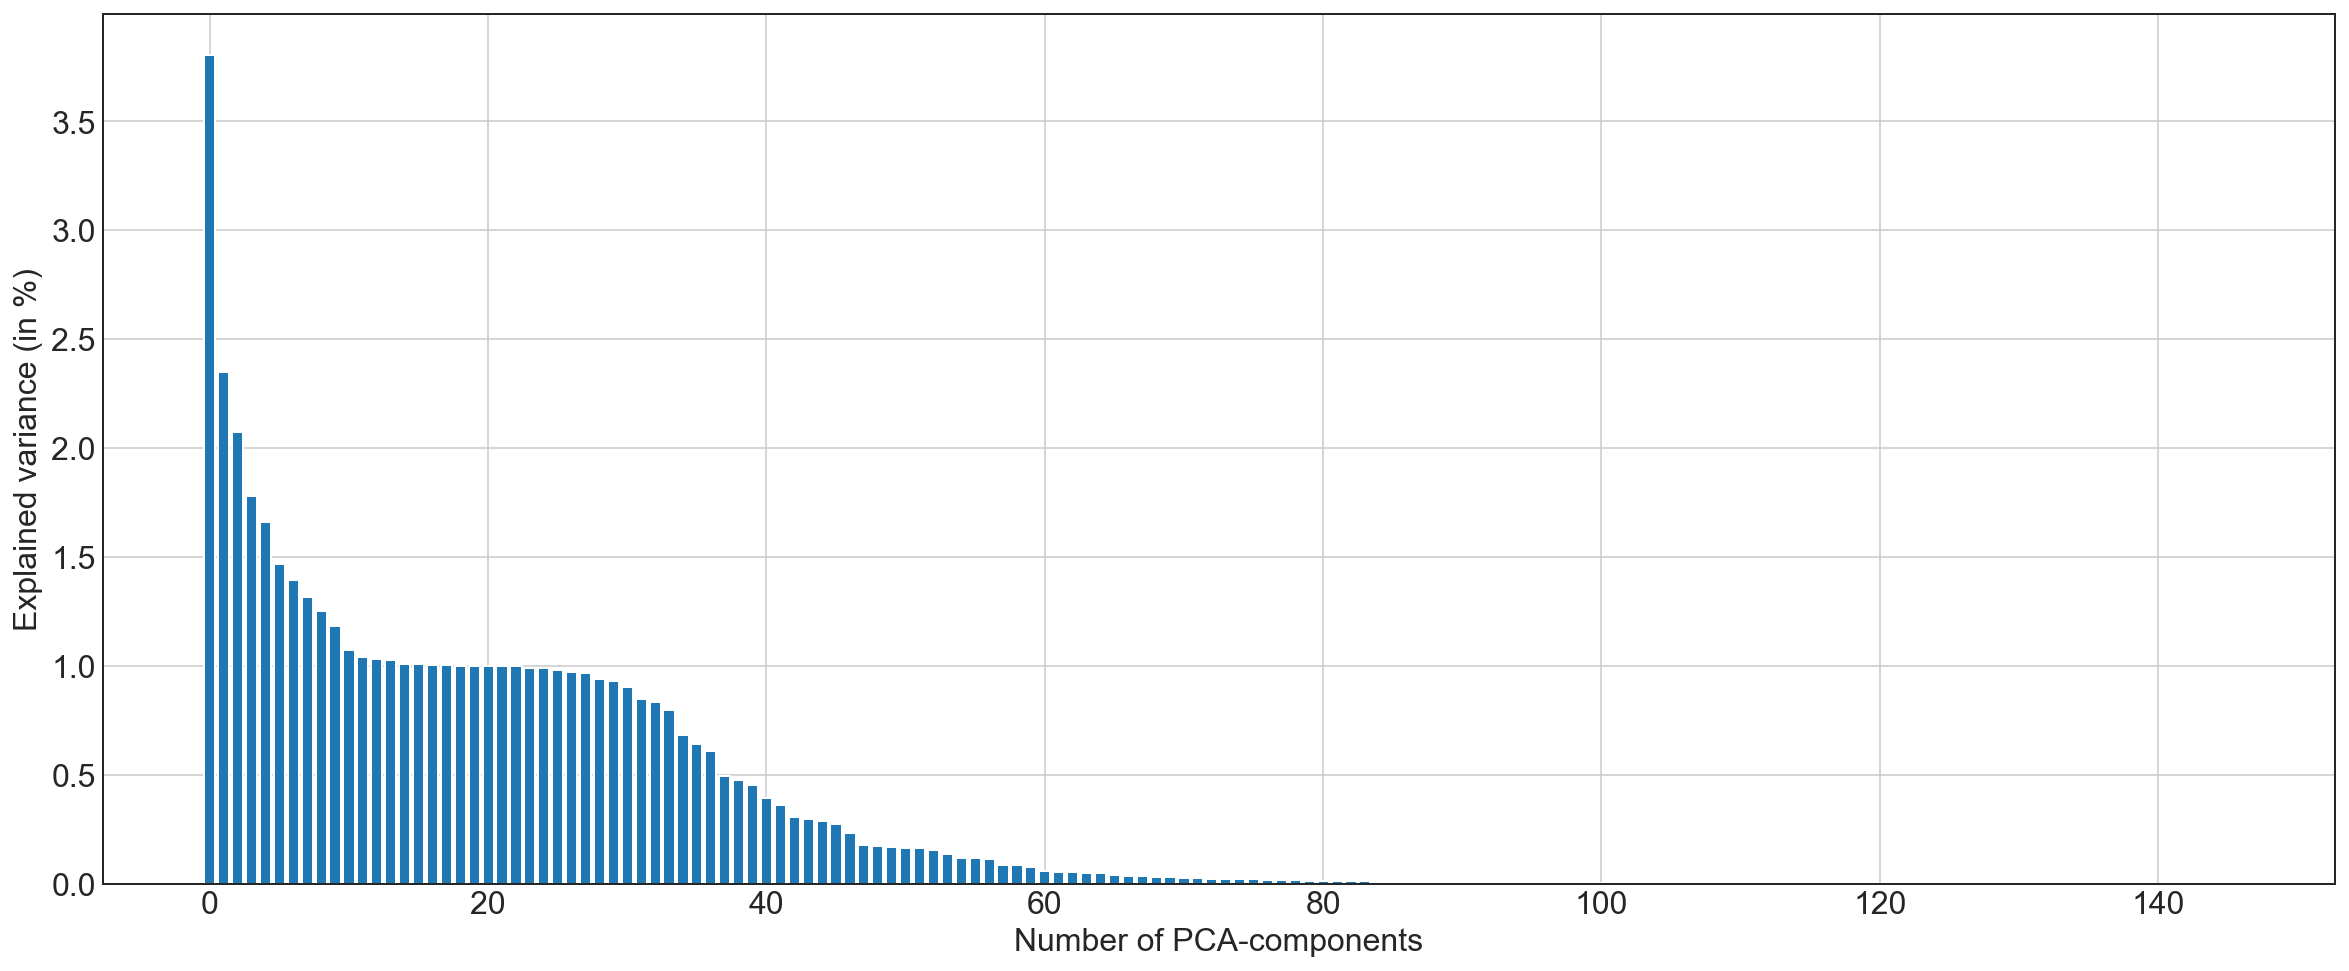

In [57]:
pca = PCA(random_state=2021)
X_train_pca = pca.fit_transform(preprocessor.fit_transform(X_train))
X_test_pca = pca.transform(preprocessor.transform(X_test))
pca.n_components = X_train_pca.shape[1]
components_amount = X_train_pca.shape[1]
pca_data = pca.fit_transform(X_train_pca)
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.xlabel('Number of PCA-components')
plt.ylabel('Explained variance (in %)')
plt.grid()
plt.show()

By looking at the plot above, one can see that for instance the first two principal components explain over 6.50% of the variation in the data. Here, the group chose the amount of components in such a way so that in total we have an explained variance of ca. 90%. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components. A general rule of thumb is to take number of principal of principal components that contribute to significant variance and ignore those with diminishing variance returns, which can be shown in the following graph:

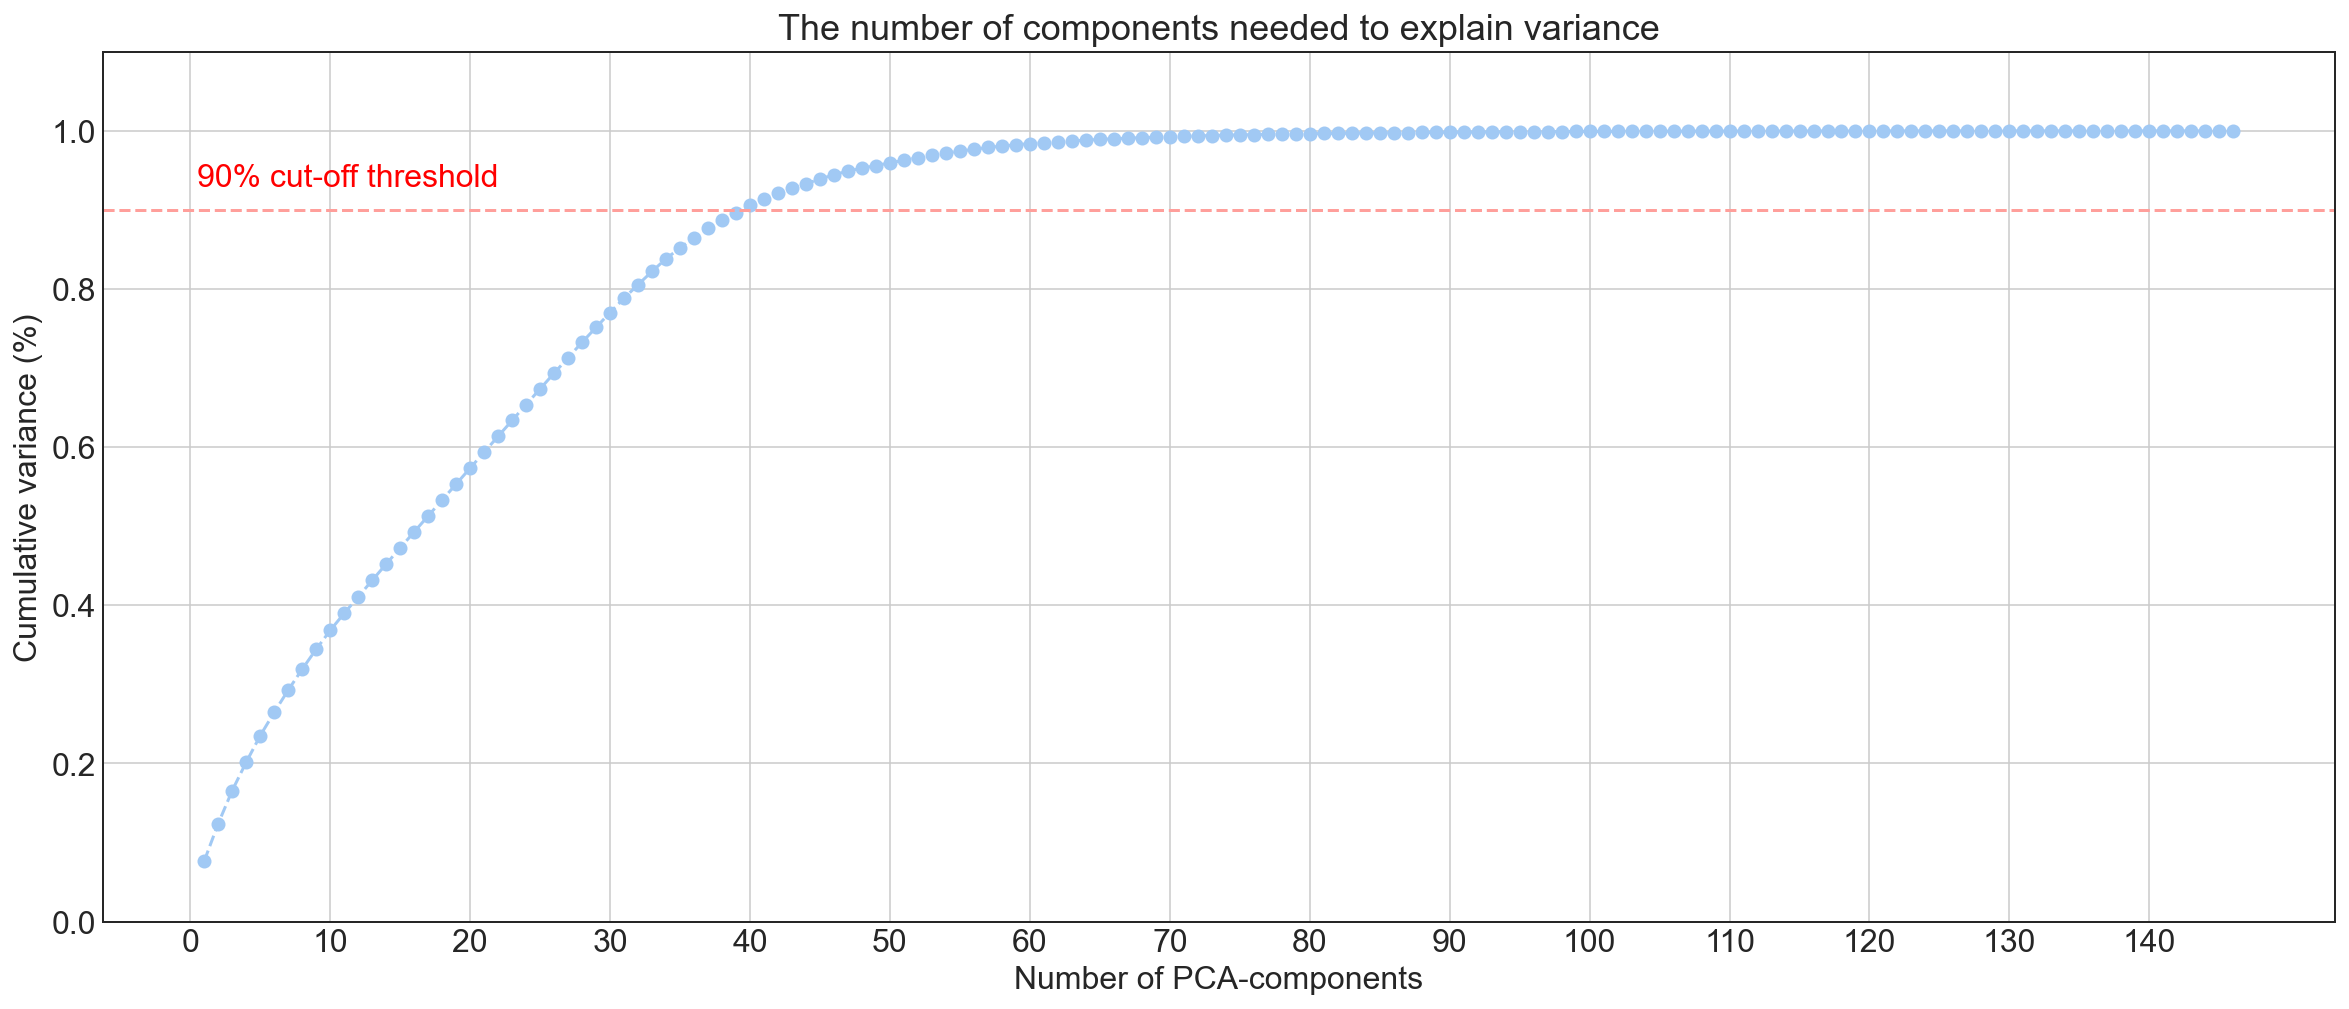

In [58]:
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots()
xi = np.arange(1, components_amount+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle = '--', color='b')
plt.xlabel('Number of PCA-components')
plt.xticks(np.arange(0, components_amount, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance', fontsize=18)
plt.axhline(y=0.90, color='r', linestyle='--')
plt.text(0.5, 0.93, '90% cut-off threshold', color = 'red', fontsize=16)
plt.grid()
plt.show()

Thus, it can be seen that 90% of the variance in the data can be achieved with roughly n = 40 principal components.

#### 4.6. Preliminary Result

We completed the first three steps of a machine learning pipeline. After defining the problem and objectives, we <br>

- **1.** Cleaned data by removing redundant and collinear features; and duplicate rows<br>
- **2.** Explored data to have a detailed understanding of the target, features and their relationships<br>
- **3.** Deleted outliers, and most importantly, prepared and transformed all three datasets<br>

The next section will show how to select a ML model and tune its hyperparameters by optimizing the selected model’s evaluation metric and most importantly, how to define beforehand, which metric to use for the classficiation problem. 

### 5. ML-Modelling

#### 5.1. Choosing a metric & optimization approach

As Andrew mentioned in his lecture, it is important that we choose the right metric when we're optimizing the model. Given that our goal is to predict potential future loan-defaults, following trade-off must be considered:

- **True positive:**  the model said they would default, and they did
- **False positive:**  the model said they would default, and they didn't
- **True negative:**  the model says they would not default, and they wouldn't
- **False negative:**  the model says they would not default, and they would

Clearly, we want to maximize **True Positives**.  When we consider our two errors, which is more costly?  Arugably, it is the **False Negative**.

Therefore, it makes sense to use a performance metric, that when the model has many **True Positives** will be high, but that will be penalized for having too many **False Negatives**. The group also checked this on Stackoverflow, and came to the same conclusion: if the cost of having False negative is high, we want to increase the model's sensitivity and recall [7].

For instance, in fraud detection or sick patient detection, we don't want to label/predict a fraudulent transaction (True Positive) as non-fraudulent (False Negative). Also, we don't want to label/predict a contagious sick patient (True Positive) as not sick (False Negative). This is because the consequences will be worse than a False Positive (incorrectly labeling a a harmless transaction as fraudulent or a non-contagious patient as contagious).

As a result, we can choose to look to the performance metric recall (also called sensitivity or hit rate), for which the formula is: **TP / (TP + FN)**.

Applying ML-models is only one side of the medal, the other, by far the most important one is to tune the models. Thus, in the following, the group summarized the most important steps in this process:
1. Define a model.<br>
2. Define the range of possible values for all hyperparameters.<br>
3. Define evaluative criteria to judge the model.<br>
4. Define a cross-validation method.

The overall aim of hyperparameter tuning is to optimize the performance of the model based on a certain metric. For example, Root Mean Squared Error (RMSE) for regression problems and recall score for our classification problem. There are several approaches to hyperparameter tuning. In this course-project, we will only apply and focus on the **RandomizedSearch**.

As the name implies, this method searches the hyperparameter space randomly for the best performance. This makes it fast and less computationally expensive. Instead of providing a set of values, we provide a statistical distribution for each hyperparameter. First implemented by Bergstra and Bengio, random search has been proven to outperform grid search [2].

In [64]:
# @hidden
###### define functions for evaluation later ######

# confusion-matrix function
def confusion_matrix_normalized (y_test, y_pred):
    plt.rcParams["figure.figsize"] = (10,7)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    categories = ['No Default','Default']
    return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories)

# for finding the best threshold (1)
def makePredThresh(fittedCls, thr = 0.5, X_test=X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

# for finding the best threshold (2)
def threshold_optimizer (y_test, model_proba):
    
    # Create the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model_proba)

    # Plot the ROC curve
    df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    gmeanOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)
    print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
    print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
    return thresholdOpt

#### 5.2. Logisitc Regression

In [23]:
# https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline
# https://www.tomasbeuzen.com/post/scikit-learn-gridsearch-pipelines/
# https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-2.html
# https://iaml.it/blog/optimizing-sklearn-pipelines
logreg = LogisticRegression(max_iter=5000, random_state=2021)
clf_logreg = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('logreg', logreg)])

params_logreg = {'logreg__C':[0.01, 0.1, 1, 5, 10, 20, 30], 
                 'logreg__penalty':['l2','l1'],
                 'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

clf_logreg = RandomizedSearchCV(estimator=clf_logreg, 
                            param_distributions = params_logreg, 
                            cv=5, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_logreg.fit(X_train, y_train);

print('Final score on training-set is: ', clf_logreg.score(X_train, y_train))
print('Final score on test-set is: ', clf_logreg.score(X_test, y_test))
print (' ')
print('\nBest params:\n', clf_logreg.best_params_)

Final score on training-set is:  0.6111412748398306
Final score on test-set is:  0.6078175895765472
 

Best params:
 {'logreg__solver': 'sag', 'logreg__penalty': 'l2', 'logreg__C': 0.01}


In [429]:
final_model_logreg = LogisticRegression(random_state=2021, 
                                        solver = "sag", 
                                        penalty = 'l2',
                                        C = 0.01)

clf_logreg = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('logreg', final_model_logreg)])
clf_logreg.fit(X_train, y_train)

print("Report:")
logreg_pred = clf_logreg.predict(X_test)

logreg_pred = clf_logreg.predict(X_test)
logreg_accuracy = round(metrics.accuracy_score(y_test, logreg_pred),4)
print ('The Accuracy of the LR-model is: {}'.format(logreg_accuracy))
print (' ')
print(classification_report(y_test, logreg_pred))

Report:
The Accuracy of the LR-model is: 0.6009
 
              precision    recall  f1-score   support

           0       0.94      0.60      0.73     34564
           1       0.12      0.60      0.20      3070

    accuracy                           0.60     37634
   macro avg       0.53      0.60      0.47     37634
weighted avg       0.88      0.60      0.69     37634



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 12%, a recall rate of 59% and an accuracy score of 62%. To refresh our knowledge of precisin, recall and accuracy, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

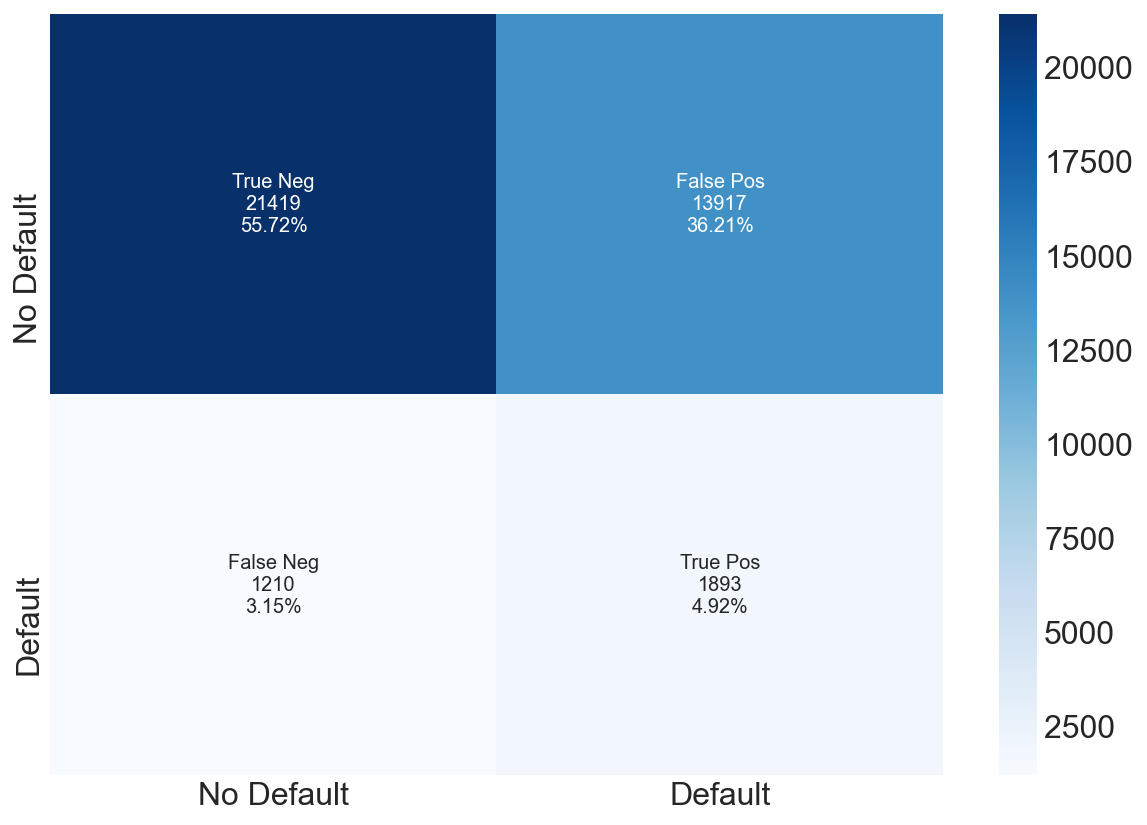

In [80]:
confusion_matrix_normalized(y_test, logreg_pred);

From the confusion matrix, we have 13.388 (34.83%) false positives. This means that our model predicted that 13.388 people won’t pay back their loans whereas these people actually paid. This is actually bad for the bank because we will be turning down people that can actually pay back their loans which will mean that we will be loosing a huge percentage of our potential customers. Our model also has 1264 false negatives. This means that our model predicted that these 1264 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.2. AdaBoost

In [74]:
ada_boost = AdaBoostClassifier(random_state = 2021)
clf_ada = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('clf', ada_boost)])

params_ada = {
    'clf__n_estimators': [20, 50, 70, 100],
    'clf__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    }

clf_ada = RandomizedSearchCV(estimator=clf_ada, 
                            param_distributions = params_ada, 
                            cv=5, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_ada.fit(X_train, y_train);

print('Final score on training-set is: ', clf_ada.score(X_train, y_train))
print('Final score on test-set is: ', clf_ada.score(X_test, y_test))
print (' ')
print('\nBest params:\n', clf_ada.best_params_)

Final score on training-set is:  0.73638414437641
Final score on test-set is:  0.7238156622623267
 

Best params:
 {'clf__n_estimators': 100, 'clf__learning_rate': 0.0001}


In [75]:
final_model_ada = AdaBoostClassifier(random_state=2021, 
                                     n_estimators = 100, 
                                     learning_rate = 0.0001)

clf_ada = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('catb', final_model_ada)])
clf_ada.fit(X_train, y_train)

print("Report:")
ada_pred = clf_ada.predict(X_test)
ada_accuracy = round(metrics.accuracy_score(y_test, ada_pred), 4)
print ('The Accuracy of the AdaBoost-model is: {}'.format(ada_accuracy))
print (' ')
print(classification_report(y_test, ada_pred))

Report:
The Accuracy of the AdaBoost-model is: 0.4148
 
              precision    recall  f1-score   support

           0       0.94      0.39      0.55     35336
           1       0.09      0.72      0.17      3103

    accuracy                           0.41     38439
   macro avg       0.52      0.55      0.36     38439
weighted avg       0.87      0.41      0.52     38439



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 9% and a recall rate of 90%. To refresh our knowledge of precision and recall, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

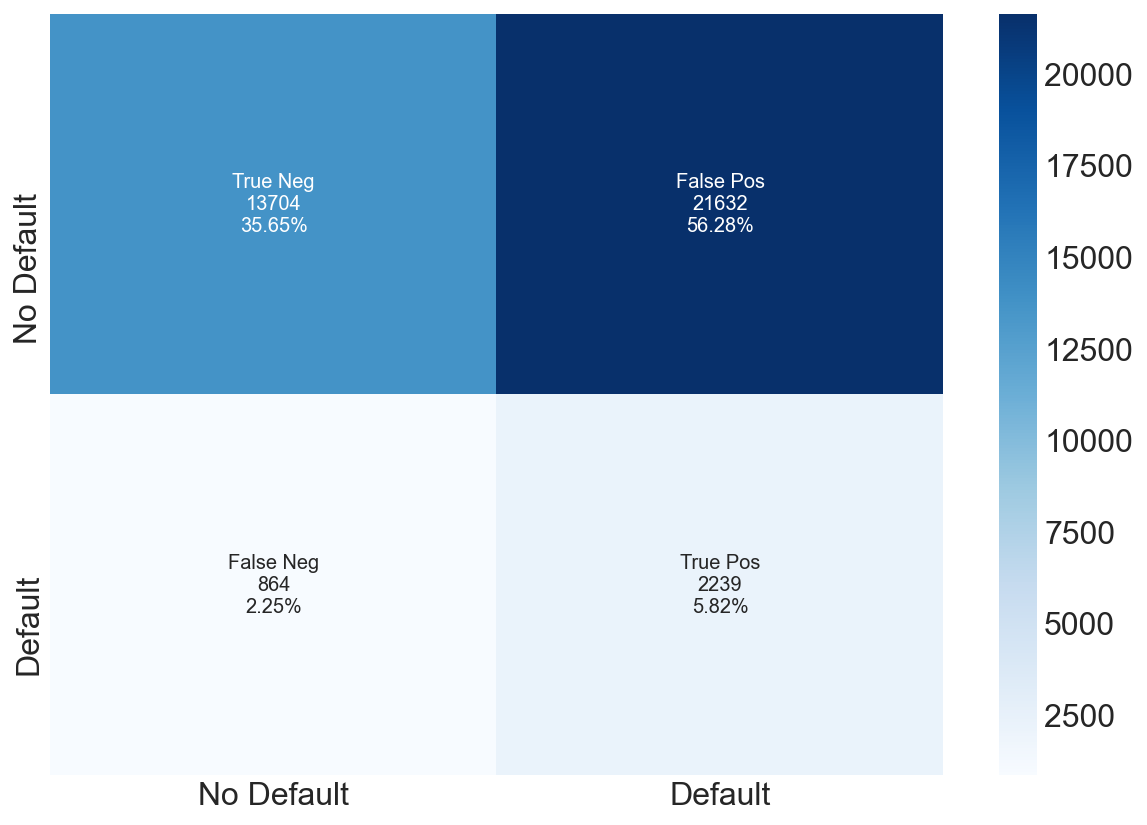

In [76]:
confusion_matrix_normalized(y_test, ada_pred);

From the confusion matrix, we have 28.514 false positives (74.18%). This means that our model predicted that 28.514 people won’t pay back their loans whereas these people actually paid. This is actually bad for business because we will be turning down people that can actually pay back their loans which will mean that we are loosing a certain percentage of our potential customers. Our model also has 3099 (0.79%) false negatives. This means is that our model predicted that these 305 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.3. CatBoost

In [71]:
# https://setscholars.net/wp-content/uploads/2019/02/find-optimal-parameters-using-RandomSearchCV-in-Regression-in-Python.html
catb = CatBoostClassifier(verbose=False, iterations=100, random_state = 2021)
clf_catb = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('catb', catb)])

params_catb = {'catb__learning_rate': sp_randFloat(),
               'catb__subsample'    : sp_randFloat(),
               'catb__max_depth'    : sp_randInt(2, 10),
               'catb__iterations'    : sp_randInt(10, 100),
              }

clf_catb = RandomizedSearchCV(estimator=clf_catb, 
                            param_distributions=params_catb, 
                            cv=2, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_catb.fit(X_train, y_train);

print('Final score on training-set is: ', clf_catb.score(X_train, y_train))
print('Final score on test-set is: ', clf_catb.score(X_test, y_test))
# Best params
print (' ')
print('\nBest params:\n', clf_catb.best_params_)

Final score on training-set is:  0.5827693629820604
Final score on test-set is:  0.5568804382855301
 

Best params:
 {'catb__iterations': 15, 'catb__learning_rate': 0.20185024783461958, 'catb__max_depth': 4, 'catb__subsample': 0.483519644998729}


In [72]:
final_model_cat = CatBoostClassifier(random_state=2021, 
                                     iterations = 15, 
                                     learning_rate = 0.20185024783461958,
                                     max_depth = 4,
                                     subsample = 0.483519644998729,
                                     verbose = False
                                     )

clf_cat = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('catb', final_model_cat)])

clf_cat.fit(X_train, y_train)

print("Report:")
cat_pred = clf_cat.predict(X_test)
gnb_accuracy = round(metrics.accuracy_score(y_test, cat_pred), 4)
print ('The Accuracy of the CatBoost-model is: {}'.format(gnb_accuracy))
print (' ')
print(classification_report(y_test, cat_pred))

Report:
The Accuracy of the CatBoost-model is: 0.6307
 
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     35336
           1       0.12      0.56      0.20      3103

    accuracy                           0.63     38439
   macro avg       0.53      0.60      0.48     38439
weighted avg       0.88      0.63      0.71     38439



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 0%, a recall rate of 0% and an accuracy score of 92%. To refresh our knowledge of precision, recall and accuracy, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

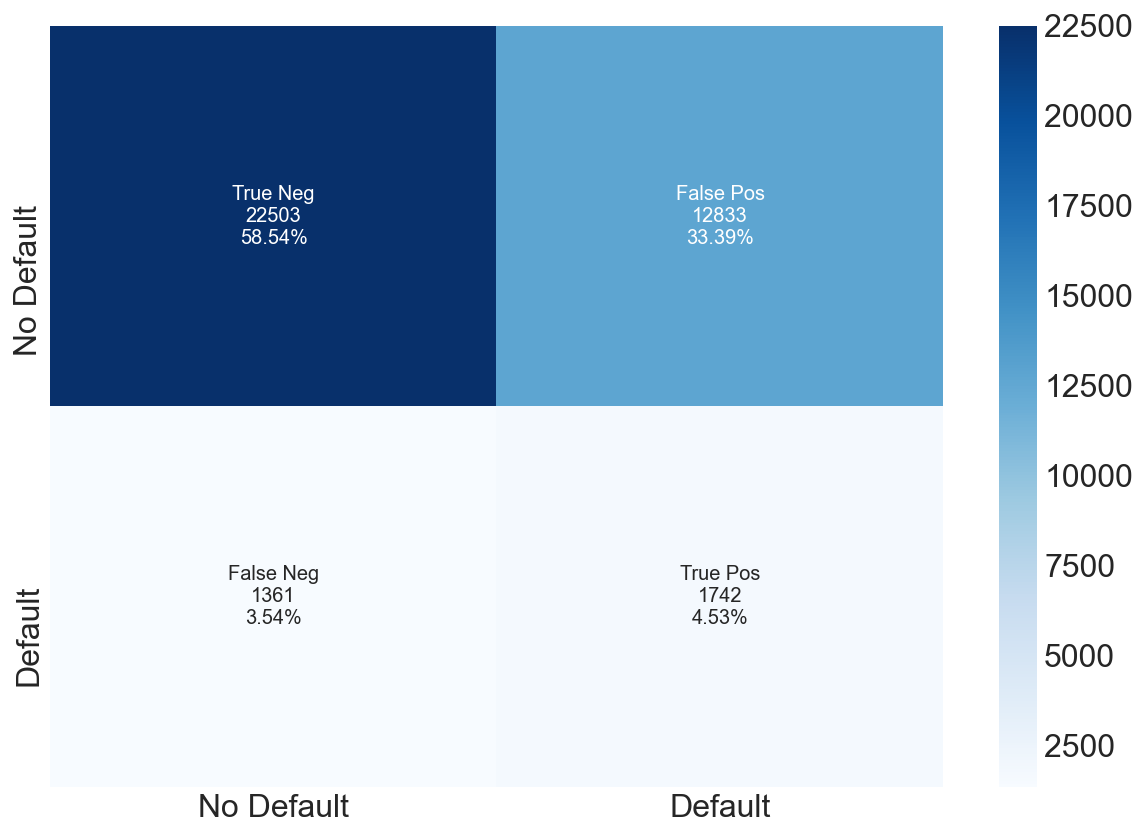

In [73]:
confusion_matrix_normalized(y_test, cat_pred);

From the confusion Matrix, we have 0 false positives (0.00%). This means that our model predicted that 0 people won’t pay back their loans whereas these people actually paid. This is actually good for the bank because it won't be turning down people that can actually pay back their loans which will mean that the bank will not loose any potential customers. Our model also has 3103 false negatives (8.07%). This means is that our model predicted that these 3103 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.4. LGBMClassifier

In [64]:
lgbm = LGBMClassifier(iterations=100, random_state = 2021)
clf_lgbm = Pipeline([('preprocessor', preprocessor), ('smt', smt), ('pca', PCA(n_components=40)), ('lgbm', lgbm)])

params_lgbm = {'lgbm__reg__alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
               'lgbm__min__child__weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
               'lgbm__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
               'lgbm__reg__lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
              }

clf_lgbm = RandomizedSearchCV(estimator=clf_lgbm, 
                            param_distributions=params_lgbm, 
                            cv=5, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_lgbm.fit(X_train, y_train);

print('Final score on training-set is: ', clf_lgbm.score(X_train, y_train))
print('Final score on test-set is: ', clf_lgbm.score(X_test, y_test))

print (' ')
print('\nBest params:\n', clf_lgbm.best_params_)

[LightGBM] [Warning] Unknown parameter: reg__alpha
[LightGBM] [Warning] Unknown parameter: min__child__weight
[LightGBM] [Warning] Unknown parameter: reg__lambda
[LightGBM] [Warning] Unknown parameter: iterations
Final score on training-set is:  0.594635682484526
Final score on test-set is:  0.4745928338762215
 

Best params:
 {'lgbm__reg_alpha': 0, 'lgbm__reg__lambda': 0, 'lgbm__reg__alpha': 50, 'lgbm__min__child__weight': 0.001}


In [65]:
# @hidden
final_model_lgbm = LGBMClassifier(reg_alpha=0.1, reg_lambda = 50, random_state=2021)
clf_lgbm = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('lgbm', final_model_lgbm)])
clf_lgbm.fit(X_train, y_train)
print("Report:")
lgbm_pred = clf_lgbm.predict(X_test)
lgbm_accuracy = round(metrics.accuracy_score(y_test, lgbm_pred), 4)
print ('The Accuracy of the LGBM-model is: {}'.format(lgbm_accuracy))
print (' ')
print(classification_report(y_test, lgbm_pred))

Report:
The Accuracy of the LGBM-model is: 0.6696
 
              precision    recall  f1-score   support

           0       0.94      0.69      0.79     34564
           1       0.12      0.49      0.19      3070

    accuracy                           0.67     37634
   macro avg       0.53      0.59      0.49     37634
weighted avg       0.87      0.67      0.74     37634



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 36%, a recall rate of 0% and an accuracy score of 92%. To refresh our knowledge of precision, recall and accuracy, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

In [66]:
# @hidden
confusion_matrix_normalized(y_test, lgbm_pred);

NameError: name 'confusion_matrix_normalized' is not defined

From the confusion matrix, we have 7 false positives (0.02%). This means that our model predicted that 7 people won’t pay back their loans whereas these people actually paid. This is actually bad for business because we will be turning down people that can actually pay back their loans which will mean that we are loosing a certain percentage of our potential customers.
Our model also has 3099 (8.06%) false negatives. This means is that our model predicted that these 3099 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.5. Pickle the models

In order to work with our models, it is important to save the predictions to a file, and then restore them in order to reuse it for later. This saving procedure is also known as object serialization - representing an object with a stream of bytes, in order to store it on disk, send it over a network or save to a database, while the restoring procedure is known as deserialization [3]. One possible approach, is to use the library **pickle**.

In [81]:
# @hidden
##########################################
############ Save the models #############
##########################################

# save: logistic regression
pickle_logreg = "log_reg.pkl"
with open(pickle_logreg, 'wb') as file:
    pickle.dump(final_model_logreg, file)
    
# save: adaboost
pickle_ada = "ada_boost.pkl"
with open(pickle_ada, 'wb') as file:
    pickle.dump(final_model_ada, file)
    
# save: lgbm
pickle_lgbm = "lgbm.pkl"
with open(pickle_lgbm, 'wb') as file:
    pickle.dump(final_model_lgbm, file)
    
# save: catboost
pickle_cat = "cat_boost.pkl"
with open(pickle_cat, 'wb') as file:
    pickle.dump(final_model_cat, file)

In [59]:
# @hidden
##########################################
############ Load the models #############
##########################################
# https://stackoverflow.com/questions/61786481/why-cant-i-read-a-joblib-file-from-my-github-repo

# load: logistic regression
logreg_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/log_reg.pkl?raw=true'
logreg_model_link = BytesIO(requests.get(logreg_model_link).content)
pickle_logreg = pickle.load(logreg_model_link)

# load: catboost
cat_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/cat_boost.pkl?raw=true'
cat_model_link = BytesIO(requests.get(cat_model_link).content)
pickle_cat = pickle.load(cat_model_link)

# load: lgbm
lgbm_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/lgbm.pkl?raw=true'
lgbm_model_link = BytesIO(requests.get(lgbm_model_link).content)
pickle_lgbm = pickle.load(lgbm_model_link)

# load: adaboost
ada_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/ada_boost.pkl?raw=true'
ada_model_link = BytesIO(requests.get(ada_model_link).content)
pickle_ada = pickle.load(ada_model_link)

#### 5.6. Model Comparisons & Threshold Fitting

##### ROC-curves

AUC-ROC curve is a performance metric for binary classification problem at different thresholds. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much model is capable of distinguishing between classes. The ideal ROC curve would be at the top left-hand corner of the image at a TPR of 1.0 and FPR of 0.0. Or in other words, ROC tells us to what extent the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By looking at the plot below, all of our models are quite above average as they are above the basic threshold which is the black dashed line.

The ROC curve is plotted with TPR (True Positive Rate, which is True Positive / [True Positive + False Negative]) against the FPR (False Positive Rate, which is [False Positive / False Positive + True Negative]) where TPR is on the y-axis and FPR is on the x-axis. ROC, other than accuracy, is widely used in imbalanced data. This is the case for credit default risk prediction because it is a combination of precision and recall.

Plotting multiple ROC-Curves in a single figure makes it easier to analyze model performances and find out the best performing model.

In [60]:
plt.rcParams["figure.figsize"] = (11,7)
logreg_pred_proba = pickle_logreg.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, logreg_pred_proba)
auc_roc_logreg = metrics.roc_auc_score(y_test, logreg_pred_proba)

ada_pred_proba = pickle_ada.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, ada_pred_proba)
auc_roc_gnb = metrics.roc_auc_score(y_test, ada_pred_proba)

cat_pred_proba = pickle_cat.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, cat_pred_proba)
auc_roc_cat = metrics.roc_auc_score(y_test, cat_pred_proba)

lgbm_pred_proba = pickle_lgbm.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, lgbm_pred_proba)
auc_roc_lgbm = metrics.roc_auc_score(y_test, lgbm_pred_proba)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label = 'LogReg (AUC = %0.2f)' % auc_roc_logreg)
plt.plot(fpr2, tpr2, label = 'GNB (AUC = %0.2f)' % auc_roc_gnb)
plt.plot(fpr3, tpr3, label = 'CatB (AUC = %0.2f)' % auc_roc_cat)
plt.plot(fpr4, tpr4, label = 'LGBM (AUC = %0.2f)' % auc_roc_lgbm)
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

ValueError: Number of features of the input must be equal to or greater than that of the fitted transformer. Transformer n_features is 58 and input n_features is 55.

**Interpretation of ROC-curve**:<br>


##### Threshold Optimization for the best classifier

The decision for converting a predicted probability or scoring into a class label is governed by a parameter referred to as the “decision threshold,” “discrimination threshold,” or simply the “threshold.” The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range between 0 or 1.

For instance, for our kind problem, credit default prediction, we have to decide that all customers whose score is above a certain threshold should not be granted a loan or should be investigated more thoroughly, which will review each case indepently. 

In general, for a binary classification problem with class labels 0 and 1, normalized predicted probabilities and a threshold of 0.5, then values less than the threshold of 0.5 are assigned to class 0 and values greater than or equal to 0.5 are assigned to class 1.
- Prediction < 0.5 = Class 0
- Prediction >= 0.5 = Class 1

The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities. Thus, in order to overcome this issue, we are using the **G-mean** to find the optimal threshold value for our classification model, which, if optimized correctly, will seek a balance between the sensitivity and the specificity. The G-Mean is defined as follows [4]:
- G-Mean = sqrt(Sensitivity * Specificity)

In [61]:
# get threshold for LGBM
lgbm_threshold = threshold_optimizer(y_test_smote, lgbm_pred_proba);

# Plot confusion matrix for LGBM with optimized threshold
pred_threshold = makePredThresh(pickle_lgbm_load, thr=lgbm_threshold, X_test = X_test_smote)
confusion_matrix_normalized(y_test_smote, pred_threshold);

NameError: name 'threshold_optimizer' is not defined

Using the G-mean as the unbiased evaluation metrics and the main focus of threshold moving, it produces the optimal threshold for the binary classification of 0.0952. Theoretically, the observation will be categorized as a minor class when its probability is lower than 0.0952, vice versa.

Best Threshold: 0.1161 with G-Mean: 0.6251
FPR: 0.3345, TPR: 0.5872


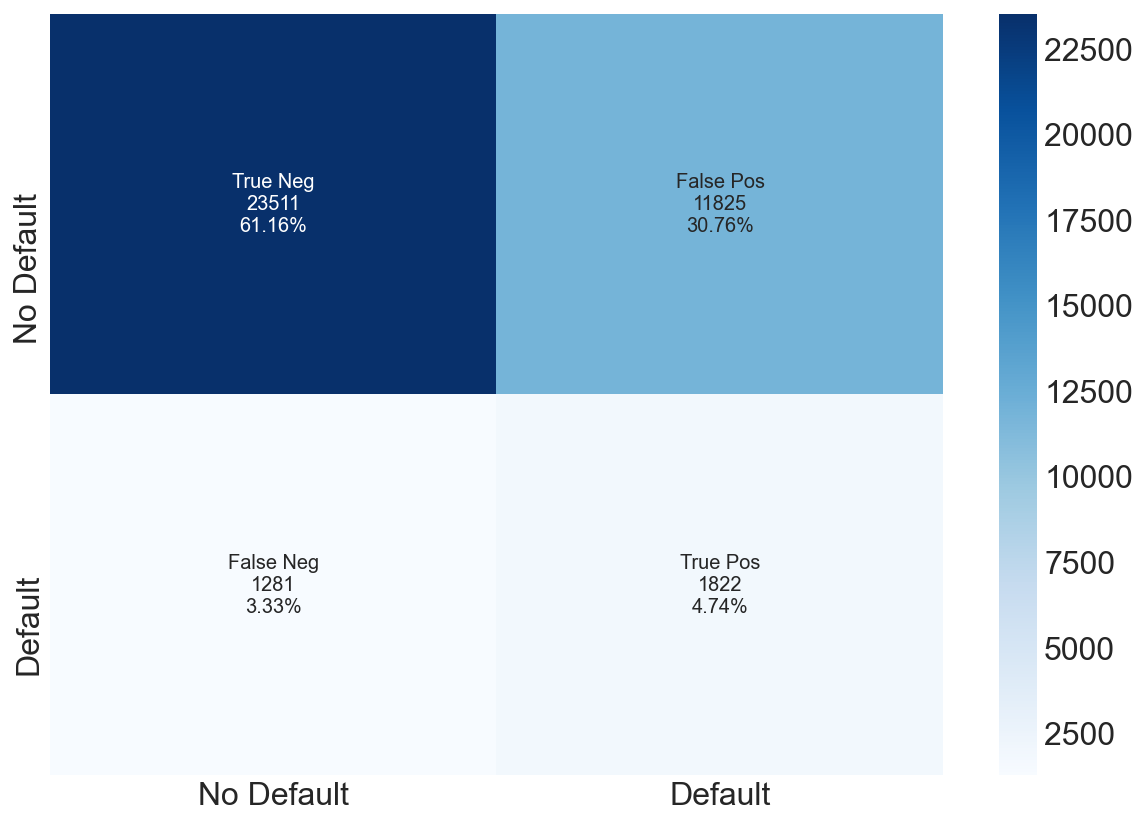

In [157]:
# get threshold for CatBoost
cat_threshold = threshold_optimizer(y_test_smote, cat_pred_proba);

# Plot confusion matrix for CatBoost with optimized threshold
pred_threshold = makePredThresh(pickle_cat_load, thr=cat_threshold, X_test = X_test_smote)
confusion_matrix_normalized(y_test_smote, pred_threshold);

Using the G-mean as the unbiased evaluation metrics and the main focus of threshold moving, it produces the optimal threshold for the binary classification of 0.1161. Theoretically, the observation will be categorized as a minor class when its probability is lower than 0.1161, vice versa.

Best Threshold: 0.493 with G-Mean: 0.6102
FPR: 0.3944, TPR: 0.6149


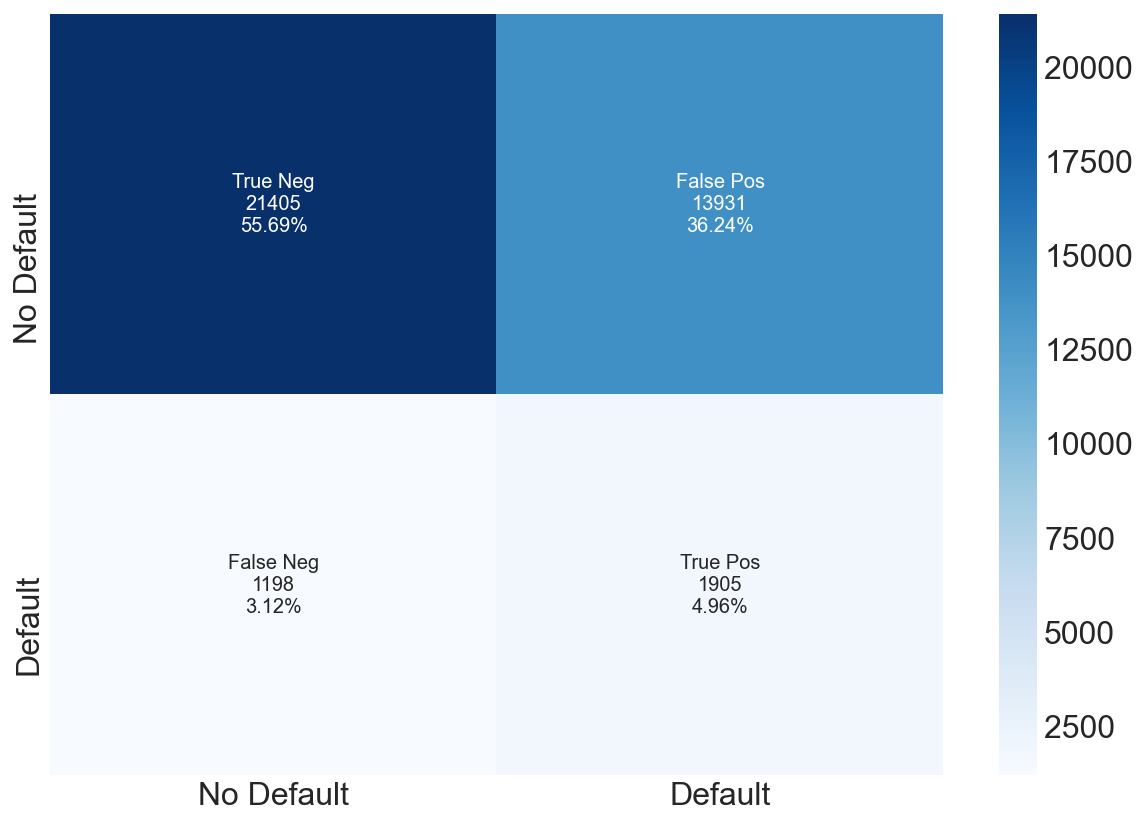

In [156]:
# get threshold for LogReg
logreg_threshold = threshold_optimizer(y_test_smote, logreg_pred_proba);

# Plot confusion matrix for LogReg with optimized threshold
pred_threshold = makePredThresh(pickle_logreg_load, thr=logreg_threshold, X_test = X_test_smote)
confusion_matrix_normalized(y_test_smote, pred_threshold);

Using the G-mean as the unbiased evaluation metrics and the main focus of threshold moving, it produces the optimal threshold for the binary classification of 0.493. Theoretically, the observation will be categorized as a minor class when its probability is lower than 0.493, vice versa.

#### 5.7. Test final (tuned) model on holdout set

In section 4.2, we divided our main dataset into three parts:
- train set
- test set
- holdout/validation set

In this section, we are evaluating the final model, i.e. our best classifier from above, with the third dataset to see how well the model actually performs on unseen data which ultimately should provide us with an unbiased evaluation of the fitted model.

In [67]:
# remove ID and TARGET from validation_set
validation_set_prediction = validation_set.drop(['SK_ID_CURR', 'TARGET'], 1)

# create y_validation (TARGET-class)
y_validation_set = validation_set['TARGET'].values

In [68]:
# apply fitted LGBM model 
lgbm_pred_validation = clf_lgbm.predict(validation_set_prediction)
lgbm_accuracy_validation = round(metrics.accuracy_score(y_validation_set, lgbm_pred_validation), 4)
print ('The Accuracy of the LGBM-model is: {}'.format(lgbm_accuracy_validation))
print (' ')
print(classification_report(y_validation_set, lgbm_pred_validation))

The Accuracy of the LGBM-model is: 0.6699
 
              precision    recall  f1-score   support

           0       0.94      0.69      0.79    138257
           1       0.12      0.48      0.19     12279

    accuracy                           0.67    150536
   macro avg       0.53      0.58      0.49    150536
weighted avg       0.87      0.67      0.74    150536



In [69]:
confusion_matrix_normalized(y_validation_set, lgbm_pred_validation);

NameError: name 'confusion_matrix_normalized' is not defined

### 6. Interpretability

In this part we will look into the feature importance of our model as well as find possible bias towards protected groups.

#### 6.1. Feature Importance

Here, we will try to look at the feature importance, even though we used PCA in our modeling. This prevents us from using SHAP in order to analyze the impact of every feature on our final prediction. We will take our test set and predict their probability score of being class 1 or default. By splitting the resulting dataframe into top 25% and bottom 25% - an approach suggested by Andrew - we run descriptive statistics to compare the differences in means of our features from our chosen model.

In [468]:
# finding the probability of being class 0 or 1 of the instances in our test set
best_clf = clf_lgbm
best_clf_proba = best_clf.predict_proba(X_test)
# creating a dataframe with all numerical variables from X_test
df_scores= X_test.copy().drop(columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'DAYS_BIRTH_BINS'])

In [447]:
encoder=OneHotEncoder(sparse=False)

train_X_encoded = pd.DataFrame (encoder.fit_transform([X_test.columns]))
#train_X_encoded.concat
train_X_encoded.shape

(1, 55)

In [326]:
# https://medium.com/user-pipeline/machine-learning-feature-encoding-with-onehotencoder-inside-a-pipeline-76d440940f4b
# https://medium.com/@oluwabukunmige/logistic-regression-in-scikit-learn-a-step-by-step-process-32f546241f32
# https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = X_test.select_dtypes(include=np.number).columns
categorical_features = X_test.select_dtypes(exclude=['number']).columns

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

smt = SMOTE(random_state = 2021)
#rfe = RFE(estimator=RandomForestClassifier(n_estimators = 50, random_state = 2021), n_features_to_select=40)

In [330]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [332]:
import sklearn
get_feature_names(preprocessor1)

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [324]:
data_dummies = pd.get_dummies(X_test)
X_test.shape
data_dummies.shape
data_dummies.columns[20:50]

Index(['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'NAME_CONTRACT_TYPE_Cash loans',
       'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y'],
      dtype='object')

In [309]:
#X_test_cols = list(X_test.columns)
df_cols = OneHotEncoder().fit_transform(preprocessor.transform(X_test)).get_feature_names([['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'DAYS_BIRTH_BINS']])
#abc = pd.DataFrame(preprocessor.transform(X_test), columns = df_cols)

#abc

AttributeError: get_feature_names not found

We add a column to our test set that shows each probability of being class 1 (or default). Then we sort them descending so the top rows show the instances that are most likely to default. Next, we create two dataframes capturing the top and bottom 25% such that we can run descriptive statistics on them.

In [448]:
df_scores['SCORE'] = best_clf_proba[:,1]
df_scores_sort = df_scores.sort_values('SCORE', ascending = False)
df_top25 = df_scores_sort.iloc[0: round(df.shape[0]*0.25)]
df_bottom25 = df_scores_sort.iloc[round(df.shape[0]*0.75):]

In [449]:
# We normalize the top and bottom 25%
norm_top25= (df_top25-df_top25.min())/(df_top25.max()-df_top25.min())
norm_bottom25 = (df_bottom25-df_bottom25.min())/(df_bottom25.max()-df_bottom25.min())

In [450]:
# dataframe showing the normalized statistics for the top 25%
top25_stats = norm_top25.describe().drop(["count", "25%", "75%"])
top25_stats

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,SCORE
mean,0.093304,0.009502,0.276728,0.170751,0.221687,0.271424,0.061596,0.747118,0.631479,NaN,0.296662,0.998087,0.158907,0.041029,0.191096,0.649766,0.51147,0.019558,0.059524,0.043474,0.186756,0.429315,0.292304,0.828884,0.000213,0.854379,NaN,0.015838,0.002870,0.000106,0.045812,0.002338,NaN,0.000319,NaN,NaN,NaN,NaN,0.000957,NaN,0.000531,NaN,0.000213,0.000531,0.186792
std,0.141270,0.011936,0.191978,0.095243,0.131221,0.191428,0.160441,0.192892,0.235993,NaN,0.456811,0.043701,0.365609,0.198368,0.155881,0.241355,0.15165,0.138482,0.236615,0.203932,0.389736,0.495005,0.454846,0.172321,0.014580,0.352744,NaN,0.124854,0.053497,0.010310,0.209088,0.048303,NaN,0.017855,NaN,NaN,NaN,NaN,0.030916,NaN,0.023049,NaN,0.014580,0.023049,0.139586
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000
50%,0.000000,0.008016,0.248089,0.159650,0.243264,0.234043,0.035552,0.774981,0.660167,NaN,0.000000,1.000000,0.000000,0.000000,0.166667,0.500000,0.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.864518,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.158376
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,1.000000,1.000000,1.000000


In [451]:
# dataframe showing the normalized statistics for the bottom 25%
bottom25_stats = norm_bottom25.describe().drop(["count", "25%", "75%"])
bottom25_stats

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,SCORE
mean,0.022640,0.042755,0.374085,0.170683,0.358844,0.624201,0.375255,0.691632,0.416176,NaN,0.112139,0.997662,0.43091,0.079082,0.070160,0.395780,0.559505,0.012436,0.047300,0.041879,0.018601,0.086416,0.078019,0.633495,NaN,0.493410,0.000638,0.018176,0.246918,0.000531,0.114477,0.006059,NaN,0.007866,NaN,0.011905,0.009460,0.005208,0.018282,0.001169,0.016794,0.001276,0.000213,NaN,0.806771
std,0.048364,0.031572,0.238378,0.099975,0.250861,0.215112,0.460881,0.175743,0.206708,NaN,0.315554,0.048303,0.49523,0.269880,0.057595,0.254869,0.134094,0.110828,0.212291,0.200324,0.135119,0.280992,0.268215,0.224404,NaN,0.499983,0.025247,0.133595,0.431241,0.023049,0.318407,0.077605,NaN,0.088344,NaN,0.108463,0.096807,0.071984,0.133978,0.034176,0.128507,0.035693,0.014580,NaN,0.154681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,0.000000,0.036524,0.328491,0.154156,0.327614,0.666667,0.041130,0.693050,0.343346,NaN,0.000000,1.000000,0.00000,0.000000,0.066667,0.500000,0.565217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.617718,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.843523
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


In [452]:
# finding the difference in means between top25 and bottom 25, dropping unimportant rows and cols, sorting values
df_diff = (top25_stats - bottom25_stats).drop(["std", "min", "50%", "max"]).drop(columns = ["SCORE"]).sort_values(by="mean", ascending=False, axis=1)
# dropping columns that don't have a difference value
df_diff = df_diff.dropna(axis='columns', how ='all')
# displaying top3 positive difference features
df_diff.iloc[:, : 3]

,FLAG_DOCUMENT_3,REG_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT
mean,0.360969,0.3429,0.253986


In [453]:
# displaying top3 negative difference features
df_diff_negative = df_diff.iloc[:, -3: ]
# sorting such that largest absolute difference is on the left
df_diff_negative.sort_values(by = "mean", axis = 1, ascending = True)

,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_PHONE
mean,-0.352777,-0.313659,-0.272003


By analyzing the two dataframes and comparing the means of the top 25% (most likely to default of all who are predicted to default) and bottom 25% (least likely to default of all who are predicted to default) of defaulting instances, will normalize the data used in X_test. Then, we will find the top 5 features of which the difference of deviations from its means is largest (top and bottom 25%). 

A large difference would imply that a mean changes a lot depending on whether an instance is in the top or bottom 25% of predicted defaulting instances. This way, we could make a statement about feature importance. Above we can see the top 3 features with those largest differences between normalized means of top and bottom 25%. We consider differences that are positive and negative as they are meaningful no matter the sign. 

Some features make intuitive sense like DAYS_EMPLOYED, which is the days before the application the person started their current employment. As this is negative it means that the top 25% of defaults have a lower mean value than the bottom 25%, indicating that the likelihood of default increases, the lower the tenure of the person in their current job. 

Another feature like REGION_RATING_CLIENT, rates the region where client lives from 1 to 3. As the difference is positive, it means that the top 25% have a higher score than the bottom 25% indicating that the higher the rating of the region, the higher the likelihood of default. 

As a small disclaimer: This feature analysis only focuses on numerical variables, while we dropped categorical ones that may be important as well. However, to ensure coherence with the modeling in which we used one-hot encoding, we excluded non-numerical features such that we avoid transforming the data in a different way for feature importance. We suggest that features like NAME_INCOME_TYPE, NAME_EDUCATION_TYPE and NAME_FAMILY_STATUS have a significant impact on the model as well because they indicate differences among instances regarding how their income is generated, highest level of education and whether they have a family or not.

#### 6.2. Auditing fairness of our model

We chose the False Negative Rate to be our metric as we want to minimize the number of instances that are predicted non-default, when in reality they would (most costly case for the bank). Had they been classified to be high risk, they would have been declined a loan.

In this part, we will look at fairness of our model. The following features represent characteristics of protected groups and may indicate unfair predictions: 

- CODE_GENDER (male or female), 
- NAME_FAMILY_STATUS (Married, Single / not married, Civil marriage, Separated, Widow),
- DAYS_BIRTH (age in days)

As we find more than two distinc values for NAME_FAMILY_STATUS, we rely on the results found in a study by Lyons and Fisher who argued that divorced men and women are more likely to default on their loans than married individuals [9]. This is why we focus on a bias audit of "Married" and "Separated" instances.

For simplicity reasons we leave out DAYS_BIRTH as this is encoded as a continuous variable, which would require binning.

In [469]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [470]:
# Create a dataframe that is properly formatted for Aequitas
X_test_copy = X_test.copy()
best_clf_pred = best_clf.predict(X_test_copy)

aequitas = X_test_copy.filter(items=["CODE_GENDER"])
aequitas["label_value"] = y_test
aequitas["score"] = best_clf_pred
df = aequitas
df.head(5)

,CODE_GENDER,label_value,score
108357,F,0,1
147943,F,1,1
144124,F,1,0
93609,F,0,0
78150,F,0,0


In [471]:
df['score'].value_counts()

0    25281
1    12353
Name: score, dtype: int64

In [472]:
protected_attributes = ['CODE_GENDER']
protected_groups = {'CODE_GENDER':'F'}

In [473]:
aq_palette = sns.diverging_palette(225, 35, n=2)

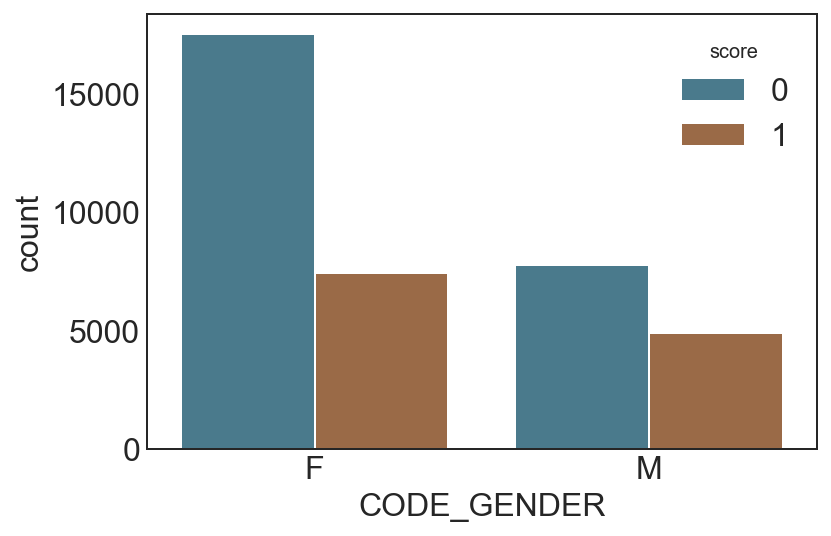

In [474]:
by_sex = sns.countplot(x="CODE_GENDER", hue="score", data=df[df.CODE_GENDER.isin(['M', 'F'])], palette=aq_palette)

Interestingly, our model predicts more defaults than non-defaults for male instances

In [475]:
g = Group()
xtab, _ = g.get_crosstabs(df)
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,12353,CODE_GENDER,F,7444,17522,6626,961,16561,818,1779,23187,24966,37634
1,0,binary 0/1,12353,CODE_GENDER,M,4909,7759,4233,615,7144,676,1291,11377,12668,37634


In [476]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,CODE_GENDER,F,0.46,0.71,0.05,0.89,0.29,0.54,0.95,0.11,0.6,0.30,0.07
1,CODE_GENDER,M,0.52,0.63,0.08,0.86,0.37,0.48,0.92,0.14,0.4,0.39,0.10


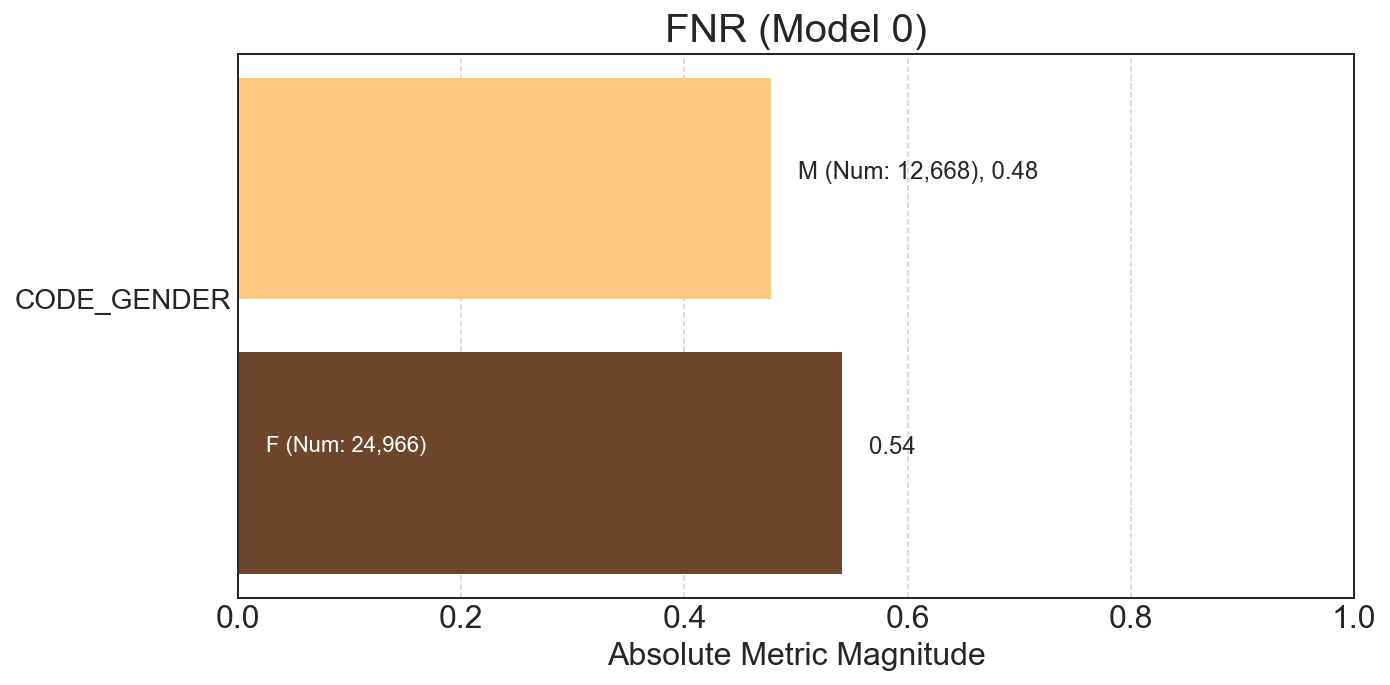

In [477]:
# plotting the FNR for CODE_GENDER
aqp = Plot()
fpr = aqp.plot_group_metric(xtab, 'fnr')

In [478]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict=protected_groups, alpha=0.05, mask_significance=True)
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

get_disparity_predefined_group()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,CODE_GENDER,F,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,CODE_GENDER,M,0.659457,1.299653,1.253161,0.968747,1.445206,1.302008,0.881864,1.138789,0.879168,0.974166


In [479]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df)
# View disparity metrics added to dataframe
min_metric_bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

get_disparity_min_metric()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,CODE_GENDER,F,1.516398,1.000000,1.000000,1.032262,1.000000,1.000000,1.133962,1.000000,1.13744,1.026519
1,CODE_GENDER,M,1.000000,1.299653,1.253161,1.000000,1.445206,1.302008,1.000000,1.138789,1.00000,1.000000


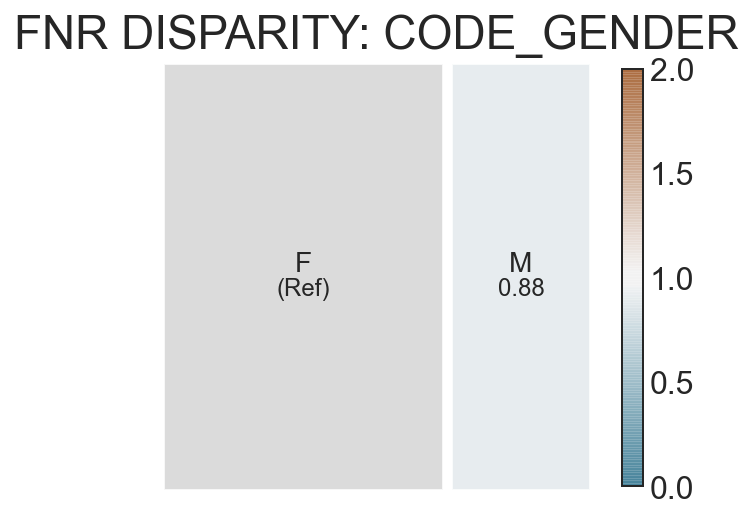

In [480]:
# plotting the FNR disparity for male and female
aqp.plot_disparity(bdf, group_metric='fnr_disparity', attribute_name='CODE_GENDER', significance_alpha=0.05)

We find a FNR Disparity of XX, which means that our model is fair with regards to gender. The rule of thumb range for a fair model is 0.85 to 1.15. Everything outside can be regarded as unfair and biased, meaning that a bias mitigation step needs to be included. However, this can be skipped for our chosen classifier.

Note: The model that performs best is actually 

In [ ]:
# interpretability:
- best model (one)
- feature importance
- issues of PCA
- shape not working
take original test-data
get score for all of them
index

- fairness/audit (gender)
- 

[1] https://towardsdatascience.com/building-an-automated-machine-learning-pipeline-part-one-5c70ae682f35<br>
[2] https://medium.com/aiplusoau/hyperparameter-tuning-a5fe69d2a6c7 <br>
[3] https://stackabuse.com/scikit-learn-save-and-restore-models/<br>
[4] https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293<br>
[5] https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/<br>
[6] https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/<br>
[7] https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc <br>
[8] https://www.kaggle.com/jainyk/anomaly-detection-using-zscore-and-modified-zscore <br>
[9] https://www.jstor.org/stable/23862267?seq=1